In [27]:
import os
import json

import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import numpy as np

import scikit_posthocs as sp
from scipy.stats import friedmanchisquare, wilcoxon
from scipy.stats import studentized_range

In [28]:
# get the path of one directory above the actual one an then get the reference to ./output/results

current_dir = os.path.dirname(os.path.abspath(os.getcwd()))
output_dir = os.path.join(current_dir, "output", "results")
print('Current dir:', current_dir)
print('Output dir:', output_dir)

Current dir: d:\masters-degree\masters-project
Output dir: d:\masters-degree\masters-project\output\results


In [29]:
# in the output_dir i have subfolders and each one of them contains some .json files that contains the results of the experiments
# i want to read all of the json files and create a pandas dataframe with them to analyze the results
# the only subfolder that i want to ignore is the "first_tests" one
# the columns of the dataframe should be: EDGE_STRATEGY, RANDOM_SEED, DOWN_SAMPLE, N, QB_LINK, GCN_RESULTS, MLP_RESULTS, RF_RESULTS
# notice that GCN_RESULTS, MLP_RESULTS and RF_RESULTS are dictionaries that contains the results of the experiments for each model


data = []
for json_file in glob(os.path.join(output_dir, "**", "*.json"), recursive=True):
    if "first_tests" not in json_file:
        with open(json_file, "r") as f:
            json_data = json.load(f)
            data.append(json_data)

# now that the json files are loaded i want to create an empty dataframe
df = pd.DataFrame()

# now i eant to set the columns names
columns = ["EDGE_STRATEGY", "RANDOM_SEED", "DOWN_SAMPLE", "N", "QB_LINK", "GCN_RESULTS", "MLP_RESULTS", "RF_RESULTS"]
df = pd.DataFrame(columns=columns)

# now i want to iterate through all of the json files and add the data to the dataframe
for item in data:
    row = {
        "EDGE_STRATEGY": item["config"]["EDGE_STRATEGY"],
        "RANDOM_SEED": item["config"]["RANDOM_SEED"],
        "DOWN_SAMPLE": item["config"]["DOWN_SAMPLE"],
        "N": item["config"]["N"],
        "QB_LINK": item["config"]["QB_LINK"],
        "GCN_RESULTS": item["best_gcn_results"],
        "MLP_RESULTS": item["mlp_results"],
        "RF_RESULTS": item["rf_results"]
    }
    # now add this row to the dataframe
    df.loc[len(df)] = row

df.tail()

,EDGE_STRATEGY,RANDOM_SEED,DOWN_SAMPLE,N,QB_LINK,GCN_RESULTS,MLP_RESULTS,RF_RESULTS
235,RNG,8,False,2,True,"{'Rush': {'precision': 0.5893108298171589, 're...","{'Rush': {'precision': 0.5932560590094836, 're...","{'Rush': {'precision': 0.6646634615384616, 're..."
236,RNG,9,True,2,True,"{'Rush': {'precision': 0.6416243654822334, 're...","{'Rush': {'precision': 0.6419386745796242, 're...","{'Rush': {'precision': 0.6906614785992218, 're..."
237,RNG,9,False,2,True,"{'Rush': {'precision': 0.5658135283363802, 're...","{'Rush': {'precision': 0.5873180873180873, 're...","{'Rush': {'precision': 0.6618876941457587, 're..."
238,RNG,10,True,2,True,"{'Rush': {'precision': 0.6388888888888888, 're...","{'Rush': {'precision': 0.6478048780487805, 're...","{'Rush': {'precision': 0.6956947162426614, 're..."
239,RNG,10,False,2,True,"{'Rush': {'precision': 0.5846438482886216, 're...","{'Rush': {'precision': 0.5639246778989098, 're...","{'Rush': {'precision': 0.6566125290023201, 're..."


In [30]:
# saving df in a csv file
df.to_csv(os.path.join(current_dir, "output", "final_results.csv"), index=False)

In [31]:
# Criar um dataframe "melted" com todos os resultados de todos os modelos ordenados por macro avg f1-score

def extract_macro_f1(results):
    if isinstance(results, dict) and 'macro avg' in results and 'f1-score' in results['macro avg']:
        return results['macro avg']['f1-score']
    return np.nan

# Criar uma lista para armazenar todos os resultados
all_results = []

# Iterar por cada linha do dataframe original
for idx, row in df.iterrows():
    # Para cada modelo, extrair o f1-score e criar uma linha no novo dataframe
    for model in ['GCN', 'MLP', 'RF']:
        macro_f1 = extract_macro_f1(row[f'{model}_RESULTS'])
        
        result_row = {
            'MODEL': model,
            'EDGE_STRATEGY': row['EDGE_STRATEGY'],
            'DOWN_SAMPLE': row['DOWN_SAMPLE'],
            'QB_LINK': row['QB_LINK'],
            'N': row['N'],
            'RANDOM_SEED': row['RANDOM_SEED'],
            'MACRO_F1_SCORE': macro_f1,
            'RESULTS': row[f'{model}_RESULTS']
        }
        all_results.append(result_row)

# Criar o dataframe com todos os resultados
df_all_results = pd.DataFrame(all_results)

# Ordenar por macro avg f1-score em ordem decrescente
df_all_results_sorted = df_all_results.sort_values('MACRO_F1_SCORE', ascending=False).reset_index(drop=True)

print("DataFrame com todos os resultados ordenados por macro avg f1-score (ordem decrescente):")
display(df_all_results_sorted[['MODEL', 'EDGE_STRATEGY', 'DOWN_SAMPLE', 'QB_LINK', 'N', 'RANDOM_SEED', 'MACRO_F1_SCORE']].head(10))

# agora descubra qual a primeira vez que aparece um modelo que não seja a gcn nesse dataframe e indique a posição
for i, row in df_all_results_sorted.iterrows():
    if row['MODEL'] != 'GCN':
        print(f"A primeira vez que aparece um modelo que não seja GCN é na posição {i}, modelo: {row['MODEL']}, EDGE_STRATEGY: {row['EDGE_STRATEGY']}, MACRO_F1_SCORE: {row['MACRO_F1_SCORE']}")
        break


DataFrame com todos os resultados ordenados por macro avg f1-score (ordem decrescente):


,MODEL,EDGE_STRATEGY,DOWN_SAMPLE,QB_LINK,N,RANDOM_SEED,MACRO_F1_SCORE
0,GCN,MST,False,False,2,5,0.779394
1,GCN,MST,False,False,2,2,0.771377
2,GCN,MST,False,False,2,6,0.767936
3,GCN,RNG,False,False,2,5,0.766915
4,GCN,MST,False,False,2,8,0.766306
5,GCN,MST,False,False,2,4,0.766292
6,GCN,MST,True,False,2,9,0.763142
7,GCN,MST,True,False,2,3,0.762814
8,GCN,RNG,False,False,2,1,0.762216
9,GCN,MST,True,False,2,1,0.760924


A primeira vez que aparece um modelo que não seja GCN é na posição 69, modelo: RF, EDGE_STRATEGY: QB-CLOSEST-, MACRO_F1_SCORE: 0.723895405792369


## Análise de F1-SCORE por EDGE_STRATEGY

Para cada EDGE_STRATEGY, será calculado o valor máximo e a média do campo `f1-score` para cada um dos modelos (GCN, MLP, RF).

Os resultados são obtidos a partir de uma cópia do dataframe original.

In [32]:
# Criar uma cópia do dataframe original para análise
import numpy as np

df_copy = df.copy()

# Função para extrair o macro avg f1-score de cada modelo
def extract_macro_f1(results):
    if isinstance(results, dict) and 'macro avg' in results and 'f1-score' in results['macro avg']:
        return results['macro avg']['f1-score']
    return np.nan

# Adiciona colunas auxiliares para cada modelo
for model in ['GCN', 'MLP', 'RF']:
    df_copy[f'{model}_MACRO_F1'] = df_copy[f'{model}_RESULTS'].apply(extract_macro_f1)

# Agrupa por EDGE_STRATEGY e calcula máximo e média do macro avg f1-score para cada modelo
agg_funcs = ['max', 'mean']
summary = df_copy.groupby('EDGE_STRATEGY')[['GCN_MACRO_F1', 'MLP_MACRO_F1', 'RF_MACRO_F1']].agg(agg_funcs)

# Exibe o resultado
summary

GCN_MACRO_F1           MLP_MACRO_F1           RF_MACRO_F1  \
                       max      mean          max      mean         max   
EDGE_STRATEGY                                                             
CLOSEST-          0.745029  0.724506     0.681617  0.662381    0.722196   
DELAUNAY          0.704524  0.661262     0.679181  0.663362    0.719191   
GABRIEL           0.730670  0.671557     0.676292  0.663816    0.723602   
MST               0.779394  0.697750     0.678063  0.663646    0.722000   
QB-CLOSEST-       0.728351  0.689017     0.680573  0.664527    0.723895   
RNG               0.766915  0.685045     0.677702  0.664610    0.720903   

                         
                   mean  
EDGE_STRATEGY            
CLOSEST-       0.708944  
DELAUNAY       0.709205  
GABRIEL        0.709425  
MST            0.708589  
QB-CLOSEST-    0.709254  
RNG            0.709022


=== MLP Values (MEAN) ===
               GCN_MACRO_F1
EDGE_STRATEGY              
CLOSEST-           0.724506
DELAUNAY           0.661262
GABRIEL            0.671557
MST                0.697750
QB-CLOSEST-        0.689017
RNG                0.685045


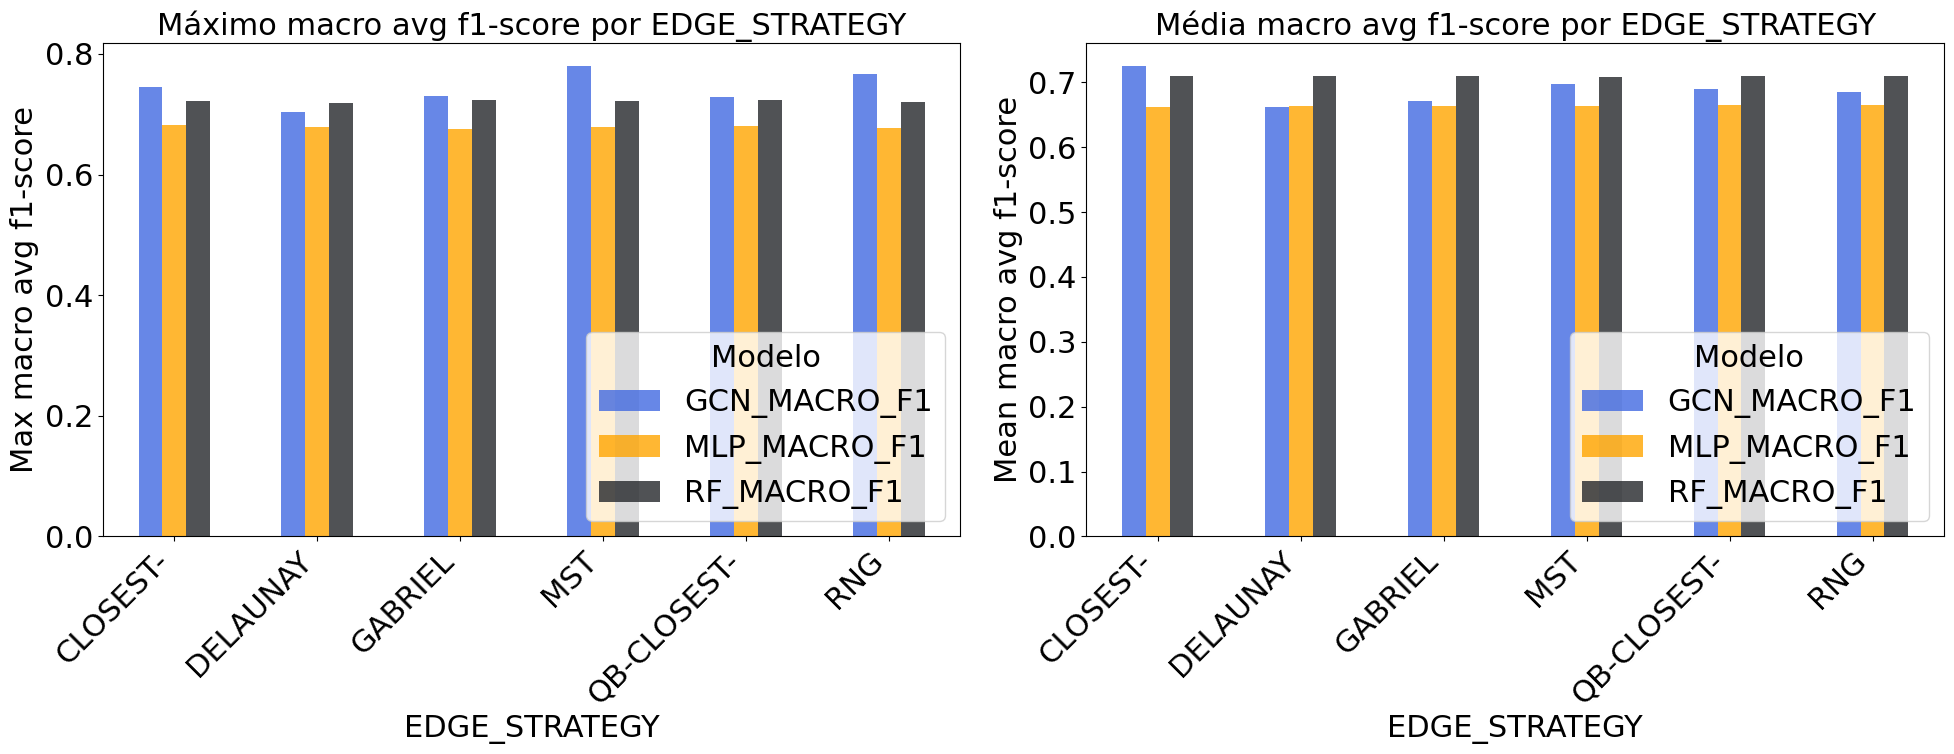

In [66]:
# Gráficos lado a lado: máximo e média de macro avg f1-score de todos os modelos por EDGE_STRATEGY
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Definir cores personalizadas para os modelos
colors = ['royalblue', 'orange', '#24272B']

# Definir tamanho da fonte
font_size = 22
plt.rcParams.update({'font.size': font_size})

# Máximo
summary_max = summary.xs('max', axis=1, level=1)

# Print all values for MLP and RF (max)
# print("=== MLP Values (MAX) ===")
# print(summary_max[['MLP_MACRO_F1']])
# print("\n=== RF Values (MAX) ===")
# print(summary_max[['RF_MACRO_F1']])

summary_max.plot(kind='bar', ax=axes[0], color=colors, alpha=0.8)
axes[0].set_title('Máximo macro avg f1-score por EDGE_STRATEGY', fontsize=font_size)
axes[0].set_ylabel('Max macro avg f1-score', fontsize=font_size)
axes[0].set_xlabel('EDGE_STRATEGY', fontsize=font_size)
axes[0].set_xticklabels(summary_max.index, rotation=45, ha='right', fontsize=font_size)
axes[0].legend(title='Modelo', loc='lower right', fontsize=font_size, title_fontsize=font_size)

# Média
summary_mean = summary.xs('mean', axis=1, level=1)

# Print all values for MLP and RF (mean)
print("\n=== MLP Values (MEAN) ===")
print(summary_mean[['GCN_MACRO_F1']])
# print("\n=== RF Values (MEAN) ===")
# print(summary_mean[['RF_MACRO_F1']])

summary_mean.plot(kind='bar', ax=axes[1], color=colors, alpha=0.8)
axes[1].set_title('Média macro avg f1-score por EDGE_STRATEGY', fontsize=font_size)
axes[1].set_ylabel('Mean macro avg f1-score', fontsize=font_size)
axes[1].set_xlabel('EDGE_STRATEGY', fontsize=font_size)
axes[1].set_xticklabels(summary_mean.index, rotation=45, ha='right', fontsize=font_size)
axes[1].legend(title='Modelo', loc='lower right', fontsize=font_size, title_fontsize=font_size)

# Ajustar espaçamento e salvar o gráfico
plt.tight_layout()
plt.savefig('macro_avg_f1_score_by_edge_strategy.pdf', format='pdf')

# Exibir o gráfico no notebook
plt.show()

### Gráficos: macro avg f1-score (máximo e média) por EDGE_STRATEGY para cada modelo

Abaixo estão gráficos de barras mostrando o valor máximo e a média do macro avg f1-score para cada EDGE_STRATEGY, separados por modelo (GCN, MLP, RF).

## Comparação do macro avg f1-score por EDGE_STRATEGY e QB_LINK

Nesta análise, para cada EDGE_STRATEGY e para cada valor de QB_LINK (True/False), será calculado o valor máximo e a média do campo `macro avg f1-score` para cada modelo (GCN, MLP, RF).

Os resultados são obtidos a partir de uma cópia do dataframe original.

In [34]:
# Nova análise: macro avg f1-score por EDGE_STRATEGY e QB_LINK

df_copy2 = df.copy()

# Função já definida anteriormente: extract_macro_f1
for model in ['GCN', 'MLP', 'RF']:
    df_copy2[f'{model}_MACRO_F1'] = df_copy2[f'{model}_RESULTS'].apply(lambda x: x['macro avg']['f1-score'] if isinstance(x, dict) and 'macro avg' in x and 'f1-score' in x['macro avg'] else np.nan)

# Agrupa por EDGE_STRATEGY e QB_LINK e calcula máximo e média do macro avg f1-score para cada modelo
agg_funcs = ['max', 'mean']
summary_qb = df_copy2.groupby(['EDGE_STRATEGY', 'QB_LINK'])[['GCN_MACRO_F1', 'MLP_MACRO_F1', 'RF_MACRO_F1']].agg(agg_funcs)

# Exibe o resultado
summary_qb

GCN_MACRO_F1           MLP_MACRO_F1            \
                               max      mean          max      mean   
EDGE_STRATEGY QB_LINK                                                 
CLOSEST-      False       0.743818  0.720417     0.681617  0.662266   
              True        0.745029  0.728595     0.678988  0.662496   
DELAUNAY      False       0.704524  0.682439     0.676465  0.661667   
              True        0.667076  0.640086     0.679181  0.665057   
GABRIEL       False       0.730670  0.705922     0.676292  0.663580   
              True        0.670400  0.637192     0.673311  0.664052   
MST           False       0.779394  0.758672     0.678063  0.664278   
              True        0.673069  0.636828     0.674783  0.663014   
QB-CLOSEST-   False       0.728351  0.696806     0.680573  0.663538   
              True        0.710748  0.681227     0.677328  0.665516   
RNG           False       0.766915  0.743963     0.676018  0.664041   
              True        0.677243  0.626126     0.677702  0.665180   

                      RF_MACRO_F1            
                              max      mean  
EDGE_STRATEGY QB_LINK                        
CLOSEST-      False      0.722196  0.709462  
              True       0.720079  0.708426  
DELAUNAY      False      0.719191  0.708436  
              True       0.719158  0.709974  
GABRIEL       False      0.723602  0.709358  
              True       0.720912  0.709493  
MST           False      0.719928  0.707724  
              True       0.722000  0.709453  
QB-CLOSEST-   False      0.721776  0.708521  
              True       0.723895  0.709987  
RNG           False      0.720903  0.709057  
              True       0.719765  0.708988

## Comparação do macro avg f1-score por EDGE_STRATEGY e DOWN_SAMPLE

Nesta análise, para cada EDGE_STRATEGY e para cada valor de DOWN_SAMPLE (True/False), será calculado o valor máximo e a média do campo `macro avg f1-score` para cada modelo (GCN, MLP, RF).

Os resultados são obtidos a partir de uma cópia do dataframe original.

In [35]:
# Nova análise: macro avg f1-score por EDGE_STRATEGY e DOWN_SAMPLE

df_copy3 = df.copy()

for model in ['GCN', 'MLP', 'RF']:
    df_copy3[f'{model}_MACRO_F1'] = df_copy3[f'{model}_RESULTS'].apply(lambda x: x['macro avg']['f1-score'] if isinstance(x, dict) and 'macro avg' in x and 'f1-score' in x['macro avg'] else np.nan)

agg_funcs = ['max', 'mean']
summary_down = df_copy3.groupby(['EDGE_STRATEGY', 'DOWN_SAMPLE'])[['GCN_MACRO_F1', 'MLP_MACRO_F1', 'RF_MACRO_F1']].agg(agg_funcs)

summary_down

GCN_MACRO_F1           MLP_MACRO_F1            \
                                   max      mean          max      mean   
EDGE_STRATEGY DOWN_SAMPLE                                                 
CLOSEST-      False           0.745029  0.731921     0.681617  0.661498   
              True            0.737931  0.717091     0.678988  0.663264   
DELAUNAY      False           0.704524  0.668155     0.677184  0.662177   
              True            0.702623  0.654370     0.679181  0.664546   
GABRIEL       False           0.729781  0.684637     0.676292  0.662495   
              True            0.730670  0.658477     0.675081  0.665138   
MST           False           0.779394  0.707498     0.673854  0.660274   
              True            0.763142  0.688002     0.678063  0.667019   
QB-CLOSEST-   False           0.728351  0.699253     0.677328  0.661713   
              True            0.715408  0.678780     0.680573  0.667341   
RNG           False           0.766915  0.705482     0.677179  0.663131   
              True            0.746461  0.664607     0.677702  0.666090   

                          RF_MACRO_F1            
                                  max      mean  
EDGE_STRATEGY DOWN_SAMPLE                        
CLOSEST-      False          0.711173  0.703700  
              True           0.722196  0.714188  
DELAUNAY      False          0.711047  0.703444  
              True           0.719191  0.714967  
GABRIEL       False          0.711568  0.703413  
              True           0.723602  0.715438  
MST           False          0.713941  0.703347  
              True           0.722000  0.713830  
QB-CLOSEST-   False          0.711568  0.704285  
              True           0.723895  0.714223  
RNG           False          0.713892  0.703694  
              True           0.720903  0.714351

## Melhor configuração para cada modelo

Nesta análise, será identificada a linha do dataframe original que apresenta o maior valor de `macro avg f1-score` para cada modelo (GCN, MLP, RF). Será exibida a configuração completa (colunas de configuração e resultados) correspondente a cada melhor resultado.

In [36]:
# Encontrar a melhor configuração para cada modelo com base no macro avg f1-score

df_best = df.copy()

# Extrai o macro avg f1-score para cada modelo
for model in ['GCN', 'MLP', 'RF']:
    df_best[f'{model}_MACRO_F1'] = df_best[f'{model}_RESULTS'].apply(lambda x: x['macro avg']['f1-score'] if isinstance(x, dict) and 'macro avg' in x and 'f1-score' in x['macro avg'] else np.nan)

# Monta o dataframe de melhores resultados
best_rows = []
for model in ['GCN', 'MLP', 'RF']:
    idx = df_best[f'{model}_MACRO_F1'].idxmax()
    row = df_best.loc[idx]
    best_rows.append({
        'Model': model,
        'Best_Accuracy': row[f'{model}_MACRO_F1'],
        'Edge_Strategy': row['EDGE_STRATEGY'],
        'Down_Sample': row['DOWN_SAMPLE'],
        'QB_Link': row['QB_LINK'],
        'N': row['N'],
        'Random_Seed': row['RANDOM_SEED']
    })

best_df = pd.DataFrame(best_rows)
best_df

,Model,Best_Accuracy,Edge_Strategy,Down_Sample,QB_Link,N,Random_Seed
0,GCN,0.779394,MST,False,False,2,5
1,MLP,0.681617,CLOSEST-,False,False,2,6
2,RF,0.723895,QB-CLOSEST-,True,True,2,8


## Gráfico comparativo: Máximo do macro avg f1-score para as classes Rush e Pass por modelo

O gráfico abaixo mostra, para cada modelo (GCN, MLP, RF), o máximo do f1-score para as classes Rush e Pass.

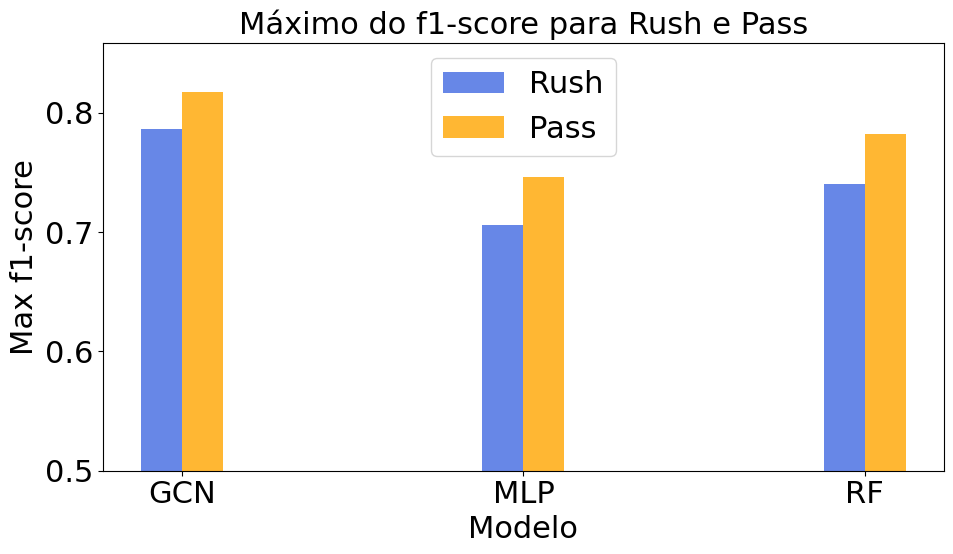

In [79]:
# Extrai os f1-scores das classes Rush e Pass para cada modelo
def extract_f1_class(results, class_name):
    if isinstance(results, dict) and class_name in results and 'f1-score' in results[class_name]:
        return results[class_name]['f1-score']
    return np.nan

means = {}
for model in ['GCN', 'MLP', 'RF']:
    rush_f1 = df[f'{model}_RESULTS'].apply(lambda x: extract_f1_class(x, 'Rush'))
    pass_f1 = df[f'{model}_RESULTS'].apply(lambda x: extract_f1_class(x, 'Pass'))
    means[model] = {
        'Rush': rush_f1.max(),
        'Pass': pass_f1.max()
    }

# Monta o dataframe para plotagem
graph_df = pd.DataFrame(means).T[['Rush', 'Pass']]

font_size = 22
plt.rcParams.update({'font.size': font_size})

# Plota o gráfico
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.12  # Mudado de 0.15 para 0.35 para corresponder ao pandas default
x = np.arange(len(graph_df.index))
ax.bar(x - bar_width/2, graph_df['Rush'], bar_width, label='Rush', color='royalblue', alpha=0.8)
ax.bar(x + bar_width/2, graph_df['Pass'], bar_width, label='Pass', color='orange', alpha=0.8)
ax.set_xticks(x)
ax.set_xticklabels(graph_df.index, fontsize=font_size)
ax.set_ylabel('Max f1-score', fontsize=font_size)
ax.set_xlabel('Modelo', fontsize=font_size)
ax.set_title('Máximo do f1-score para Rush e Pass', fontsize=font_size)
ax.set_ylim(bottom=0.5)
ax.legend(fontsize=font_size)
plt.tight_layout()
plt.savefig('max_f1_score_rush_pass.pdf', format='pdf')
plt.show()

## Análise do impacto do parâmetro QB_LINK em cada EDGE_STRATEGY e modelo

O gráfico abaixo mostra, para cada EDGE_STRATEGY e para cada modelo (GCN, MLP, RF), a média do macro avg f1-score separando os casos em que QB_LINK é True e False.

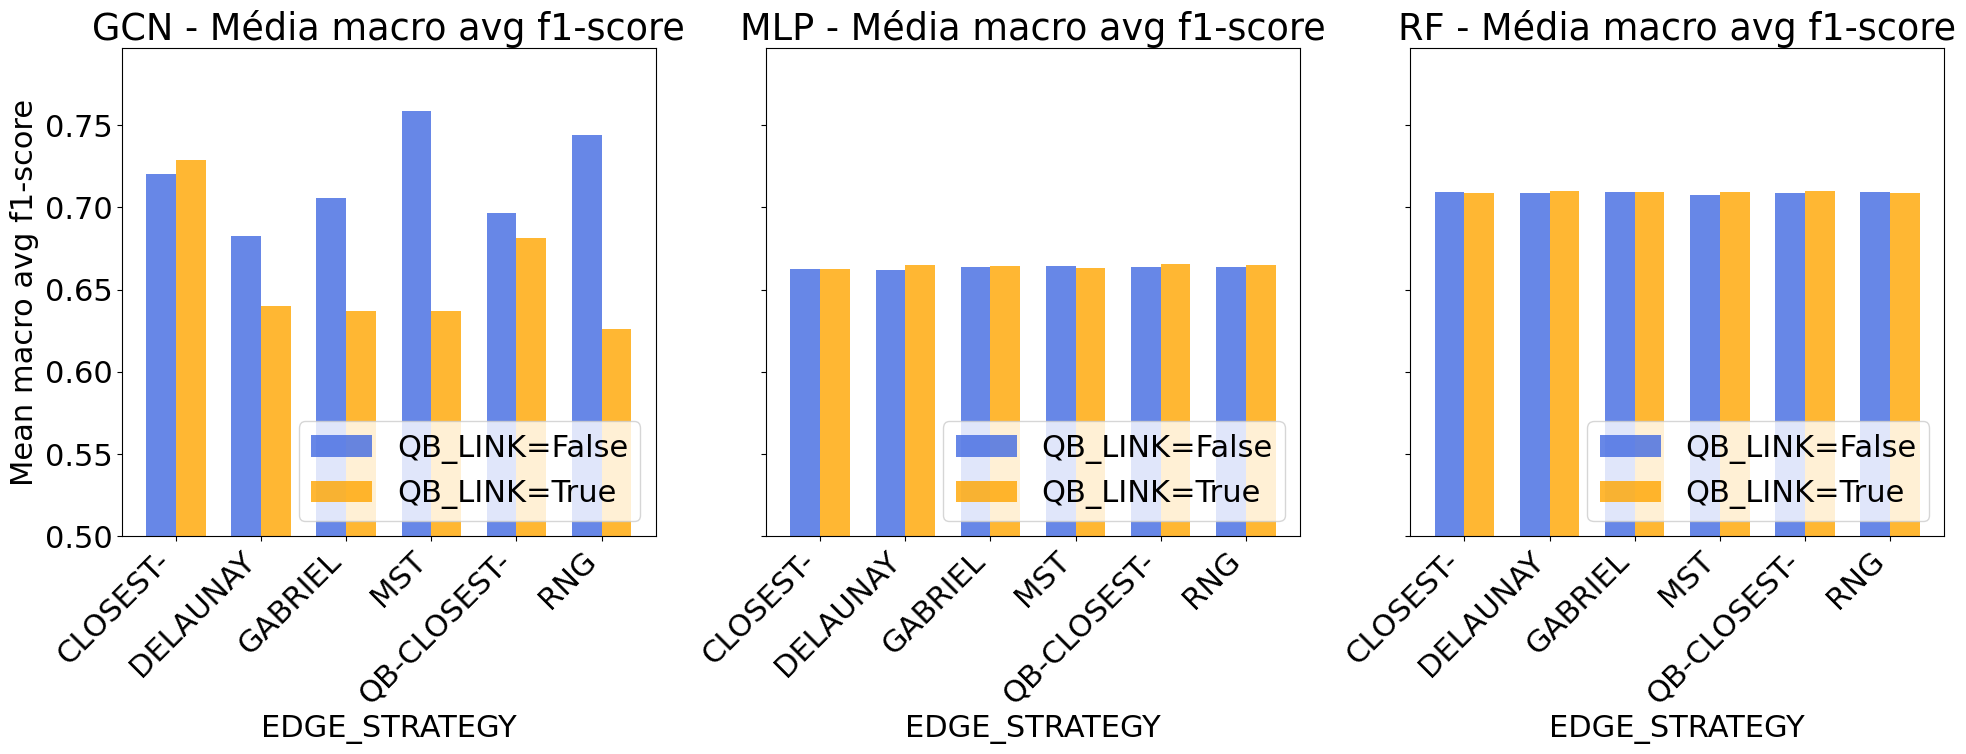

In [64]:
# Análise do impacto do parâmetro QB_LINK para cada EDGE_STRATEGY e modelo

df_qb = df.copy()

# Extrai macro avg f1-score para cada modelo
for model in ['GCN', 'MLP', 'RF']:
    df_qb[f'{model}_MACRO_F1'] = df_qb[f'{model}_RESULTS'].apply(lambda x: x['macro avg']['f1-score'] if isinstance(x, dict) and 'macro avg' in x and 'f1-score' in x['macro avg'] else np.nan)

# Agrupa por EDGE_STRATEGY e QB_LINK e calcula a média do macro avg f1-score para cada modelo
summary_qb = df_qb.groupby(['EDGE_STRATEGY', 'QB_LINK'])[['GCN_MACRO_F1', 'MLP_MACRO_F1', 'RF_MACRO_F1']].mean().reset_index()

# Plota gráfico para cada modelo com barras lado a lado
fig, axes = plt.subplots(1, 3, figsize=(20, 8), sharey=True)
models = ['GCN', 'MLP', 'RF']

# Preparar dados para barras lado a lado
edge_strategies = summary_qb['EDGE_STRATEGY'].unique()
bar_width = 0.35
x = np.arange(len(edge_strategies))

for i, model in enumerate(models):
    # Dados para QB_LINK=False e QB_LINK=True
    data_false = summary_qb[summary_qb['QB_LINK'] == False].set_index('EDGE_STRATEGY')[f'{model}_MACRO_F1']
    data_true = summary_qb[summary_qb['QB_LINK'] == True].set_index('EDGE_STRATEGY')[f'{model}_MACRO_F1']
    
    # Alinhar dados com as edge_strategies (preencher com NaN se ausente)
    data_false = data_false.reindex(edge_strategies)
    data_true = data_true.reindex(edge_strategies)
    
    axes[i].bar(x - bar_width/2, data_false, bar_width, label='QB_LINK=False', color='royalblue', alpha=0.8)
    axes[i].bar(x + bar_width/2, data_true, bar_width, label='QB_LINK=True', color='orange', alpha=0.8)
    
    axes[i].set_title(f'{model} - Média macro avg f1-score')
    axes[i].set_xlabel('EDGE_STRATEGY')
    axes[i].set_xticks(x)
    axes[i].set_xticklabels(edge_strategies, rotation=45, ha='right')
    axes[i].set_ylim(bottom=0.5)
    if i == 0:
        axes[i].set_ylabel('Mean macro avg f1-score')
    axes[i].legend(loc='lower right')

plt.tight_layout()
plt.savefig('impact_of_qb_link.pdf', format='pdf')
plt.show()

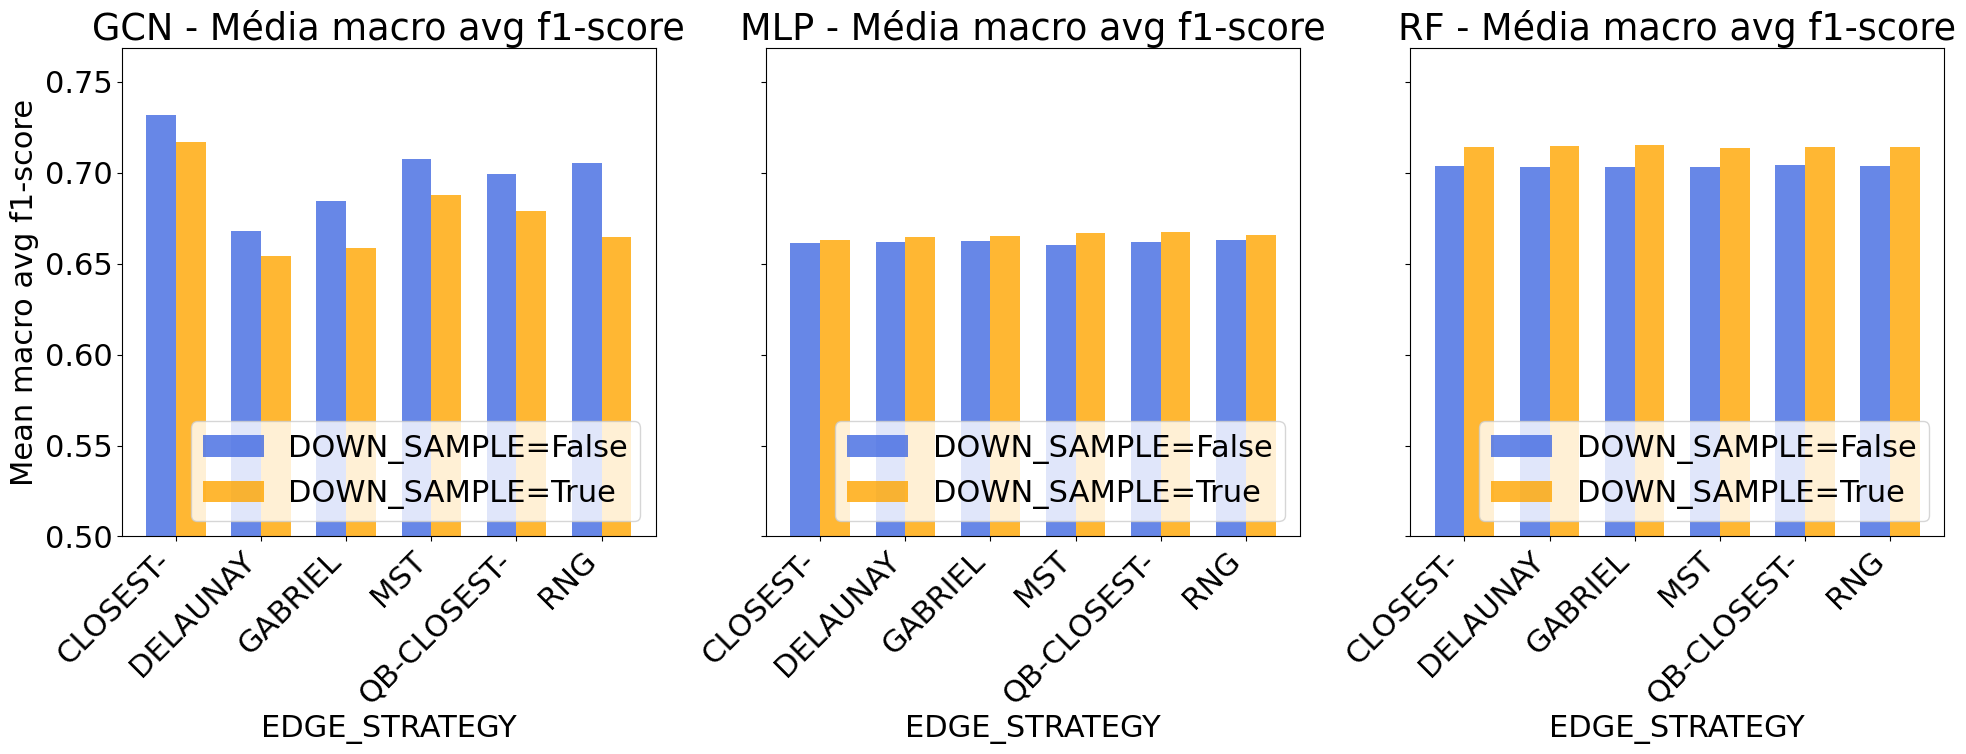

In [39]:
# Análise do impacto do parâmetro DOWN_SAMPLE para cada EDGE_STRATEGY e modelo

df_down = df.copy()

# Extrai macro avg f1-score para cada modelo
for model in ['GCN', 'MLP', 'RF']:
    df_down[f'{model}_MACRO_F1'] = df_down[f'{model}_RESULTS'].apply(lambda x: x['macro avg']['f1-score'] if isinstance(x, dict) and 'macro avg' in x and 'f1-score' in x['macro avg'] else np.nan)

# Agrupa por EDGE_STRATEGY e DOWN_SAMPLE e calcula a média do macro avg f1-score para cada modelo
summary_down = df_down.groupby(['EDGE_STRATEGY', 'DOWN_SAMPLE'])[['GCN_MACRO_F1', 'MLP_MACRO_F1', 'RF_MACRO_F1']].mean().reset_index()

# Plota gráfico para cada modelo com barras lado a lado
fig, axes = plt.subplots(1, 3, figsize=(20, 8), sharey=True)
models = ['GCN', 'MLP', 'RF']

# Preparar dados para barras lado a lado
edge_strategies = summary_down['EDGE_STRATEGY'].unique()
bar_width = 0.35
x = np.arange(len(edge_strategies))

for i, model in enumerate(models):
    # Dados para DOWN_SAMPLE=False e DOWN_SAMPLE=True
    data_false = summary_down[summary_down['DOWN_SAMPLE'] == False].set_index('EDGE_STRATEGY')[f'{model}_MACRO_F1']
    data_true = summary_down[summary_down['DOWN_SAMPLE'] == True].set_index('EDGE_STRATEGY')[f'{model}_MACRO_F1']
    
    # Alinhar dados com as edge_strategies (preencher com NaN se ausente)
    data_false = data_false.reindex(edge_strategies)
    data_true = data_true.reindex(edge_strategies)
    
    axes[i].bar(x - bar_width/2, data_false, bar_width, label='DOWN_SAMPLE=False', color='royalblue', alpha=0.8)
    axes[i].bar(x + bar_width/2, data_true, bar_width, label='DOWN_SAMPLE=True', color='orange', alpha=0.8)
    
    axes[i].set_title(f'{model} - Média macro avg f1-score')
    axes[i].set_xlabel('EDGE_STRATEGY')
    axes[i].set_xticks(x)
    axes[i].set_xticklabels(edge_strategies, rotation=45, ha='right')
    axes[i].set_ylim(bottom=0.5)
    if i == 0:
        axes[i].set_ylabel('Mean macro avg f1-score')
    axes[i].legend(loc='lower right')

plt.tight_layout()
plt.savefig('impact_of_down_sample.pdf', format='pdf')
plt.show()

## Comparação de Matrizes de Confusão entre Modelos

Nesta seção serão apresentadas duas visualizações comparativas das matrizes de confusão:

1. **Melhores resultados**: Matrizes de confusão dos melhores resultados de cada modelo (baseado no maior macro avg f1-score)
2. **Médias**: Matrizes de confusão calculadas a partir da média de todas as matrizes de confusão de cada modelo

In [40]:
# Função auxiliar para extrair matriz de confusão
def extract_confusion_matrix(results):
    if isinstance(results, dict) and 'confusion_matrix' in results:
        return np.array(results['confusion_matrix'])
    return None

# Preparar dados para as matrizes de confusão separadas por DOWN_SAMPLE
df_confusion = df.copy()

# Extrair matrizes de confusão e macro avg f1-score para cada modelo
for model in ['GCN', 'MLP', 'RF']:
    df_confusion[f'{model}_MACRO_F1'] = df_confusion[f'{model}_RESULTS'].apply(extract_macro_f1)
    df_confusion[f'{model}_CONFUSION'] = df_confusion[f'{model}_RESULTS'].apply(extract_confusion_matrix)

# Separar por DOWN_SAMPLE
df_downsample_true = df_confusion[df_confusion['DOWN_SAMPLE'] == True]
df_downsample_false = df_confusion[df_confusion['DOWN_SAMPLE'] == False]

print(f"Experimentos com DOWN_SAMPLE=True: {len(df_downsample_true)}")
print(f"Experimentos com DOWN_SAMPLE=False: {len(df_downsample_false)}")

# Encontrar os melhores resultados para DOWN_SAMPLE=True
best_confusion_matrices_true = {}
print("\n=== MELHORES RESULTADOS - DOWN_SAMPLE=True ===")
for model in ['GCN', 'MLP', 'RF']:
    if len(df_downsample_true) > 0:
        idx = df_downsample_true[f'{model}_MACRO_F1'].idxmax()
        best_confusion_matrices_true[model] = df_downsample_true.loc[idx, f'{model}_CONFUSION']
        print(f"Melhor {model} - Macro avg f1-score: {df_downsample_true.loc[idx, f'{model}_MACRO_F1']:.4f}")
    else:
        best_confusion_matrices_true[model] = np.array([[0, 0], [0, 0]])
        print(f"Nenhum experimento encontrado para {model}")

# Encontrar os melhores resultados para DOWN_SAMPLE=False
best_confusion_matrices_false = {}
print("\n=== MELHORES RESULTADOS - DOWN_SAMPLE=False ===")
for model in ['GCN', 'MLP', 'RF']:
    if len(df_downsample_false) > 0:
        idx = df_downsample_false[f'{model}_MACRO_F1'].idxmax()
        best_confusion_matrices_false[model] = df_downsample_false.loc[idx, f'{model}_CONFUSION']
        print(f"Melhor {model} - Macro avg f1-score: {df_downsample_false.loc[idx, f'{model}_MACRO_F1']:.4f}")
    else:
        best_confusion_matrices_false[model] = np.array([[0, 0], [0, 0]])
        print(f"Nenhum experimento encontrado para {model}")

Experimentos com DOWN_SAMPLE=True: 120
Experimentos com DOWN_SAMPLE=False: 120

=== MELHORES RESULTADOS - DOWN_SAMPLE=True ===
Melhor GCN - Macro avg f1-score: 0.7631
Melhor MLP - Macro avg f1-score: 0.6806
Melhor RF - Macro avg f1-score: 0.7239

=== MELHORES RESULTADOS - DOWN_SAMPLE=False ===
Melhor GCN - Macro avg f1-score: 0.7794
Melhor MLP - Macro avg f1-score: 0.6816
Melhor RF - Macro avg f1-score: 0.7139


In [41]:
# Calcular as médias das matrizes de confusão para cada modelo separadas por DOWN_SAMPLE
mean_confusion_matrices_true = {}
mean_confusion_matrices_false = {}

print("=== MÉDIAS DAS MATRIZES - DOWN_SAMPLE=True ===")
for model in ['GCN', 'MLP', 'RF']:
    # Filtrar apenas matrizes válidas para DOWN_SAMPLE=True
    valid_matrices_true = [matrix for matrix in df_downsample_true[f'{model}_CONFUSION'] if matrix is not None]
    
    if valid_matrices_true:
        mean_matrix = np.mean(valid_matrices_true, axis=0)
        mean_confusion_matrices_true[model] = mean_matrix.astype(int)
        print(f"Média {model} (baseada em {len(valid_matrices_true)} experimentos):")
        print(f"{mean_matrix}")
        print()
    else:
        mean_confusion_matrices_true[model] = np.array([[0, 0], [0, 0]])
        print(f"Nenhuma matriz válida encontrada para {model}")

print("=== MÉDIAS DAS MATRIZES - DOWN_SAMPLE=False ===")
for model in ['GCN', 'MLP', 'RF']:
    # Filtrar apenas matrizes válidas para DOWN_SAMPLE=False
    valid_matrices_false = [matrix for matrix in df_downsample_false[f'{model}_CONFUSION'] if matrix is not None]
    
    if valid_matrices_false:
        mean_matrix = np.mean(valid_matrices_false, axis=0)
        mean_confusion_matrices_false[model] = mean_matrix.astype(int)
        print(f"Média {model} (baseada em {len(valid_matrices_false)} experimentos):")
        print(f"{mean_matrix}")
        print()
    else:
        mean_confusion_matrices_false[model] = np.array([[0, 0], [0, 0]])
        print(f"Nenhuma matriz válida encontrada para {model}")

=== MÉDIAS DAS MATRIZES - DOWN_SAMPLE=True ===
Média GCN (baseada em 120 experimentos):
[[720.80833333 195.19166667]
 [383.34166667 532.65833333]]

Média MLP (baseada em 120 experimentos):
[[644.15833333 271.84166667]
 [339.63333333 576.36666667]]

Média RF (baseada em 120 experimentos):
[[712.4 203.6]
 [317.4 598.6]]

=== MÉDIAS DAS MATRIZES - DOWN_SAMPLE=False ===
Média GCN (baseada em 120 experimentos):
[[ 615.79166667  300.20833333]
 [ 369.125      1028.875     ]]

Média MLP (baseada em 120 experimentos):
[[560.30833333 355.69166667]
 [398.19166667 999.80833333]]

Média RF (baseada em 120 experimentos):
[[ 556.825  359.175]
 [ 287.275 1110.725]]



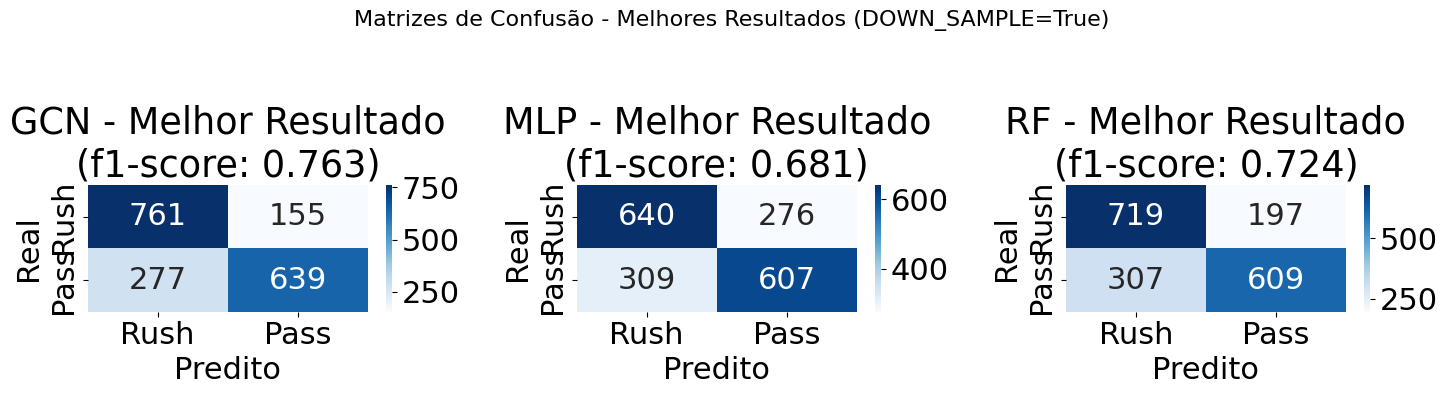

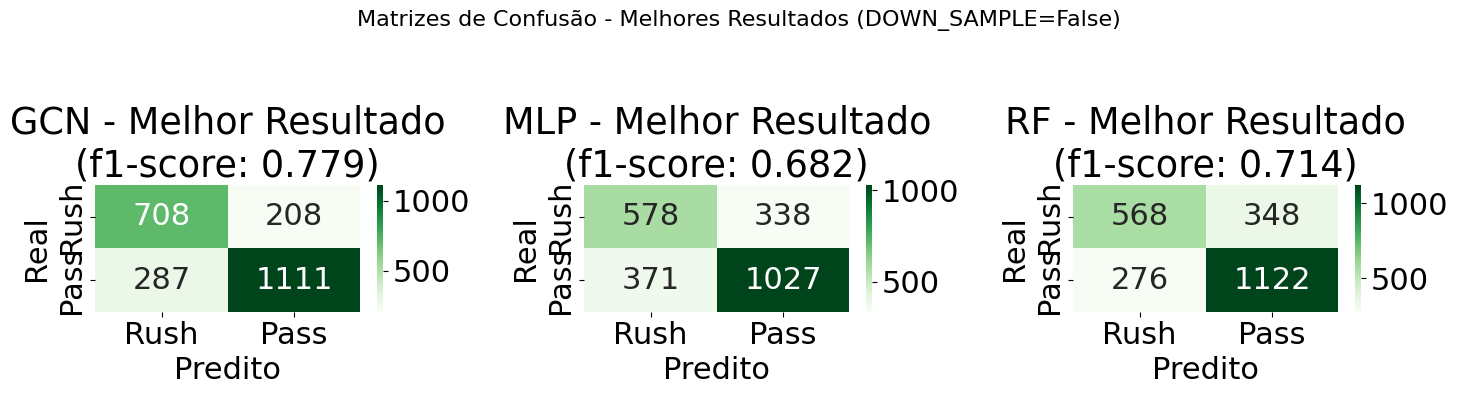

In [42]:
# Visualização das matrizes de confusão dos melhores resultados - DOWN_SAMPLE=True
import seaborn as sns

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
models = ['GCN', 'MLP', 'RF']
class_names = ['Rush', 'Pass']

for i, model in enumerate(models):
    matrix = best_confusion_matrices_true[model]
    
    # Criar heatmap
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names,
                ax=axes[i], cbar=True)
    
    # Obter f1-score do melhor resultado para DOWN_SAMPLE=True
    if len(df_downsample_true) > 0:
        best_f1 = df_downsample_true[f'{model}_MACRO_F1'].max()
        axes[i].set_title(f'{model} - Melhor Resultado\n(f1-score: {best_f1:.3f})')
    else:
        axes[i].set_title(f'{model} - Melhor Resultado\n(Sem dados)')
    
    axes[i].set_xlabel('Predito')
    axes[i].set_ylabel('Real')

plt.suptitle('Matrizes de Confusão - Melhores Resultados (DOWN_SAMPLE=True)', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

# Visualização das matrizes de confusão dos melhores resultados - DOWN_SAMPLE=False
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, model in enumerate(models):
    matrix = best_confusion_matrices_false[model]
    
    # Criar heatmap
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Greens', 
                xticklabels=class_names, yticklabels=class_names,
                ax=axes[i], cbar=True)
    
    # Obter f1-score do melhor resultado para DOWN_SAMPLE=False
    if len(df_downsample_false) > 0:
        best_f1 = df_downsample_false[f'{model}_MACRO_F1'].max()
        axes[i].set_title(f'{model} - Melhor Resultado\n(f1-score: {best_f1:.3f})')
    else:
        axes[i].set_title(f'{model} - Melhor Resultado\n(Sem dados)')
    
    axes[i].set_xlabel('Predito')
    axes[i].set_ylabel('Real')

plt.suptitle('Matrizes de Confusão - Melhores Resultados (DOWN_SAMPLE=False)', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

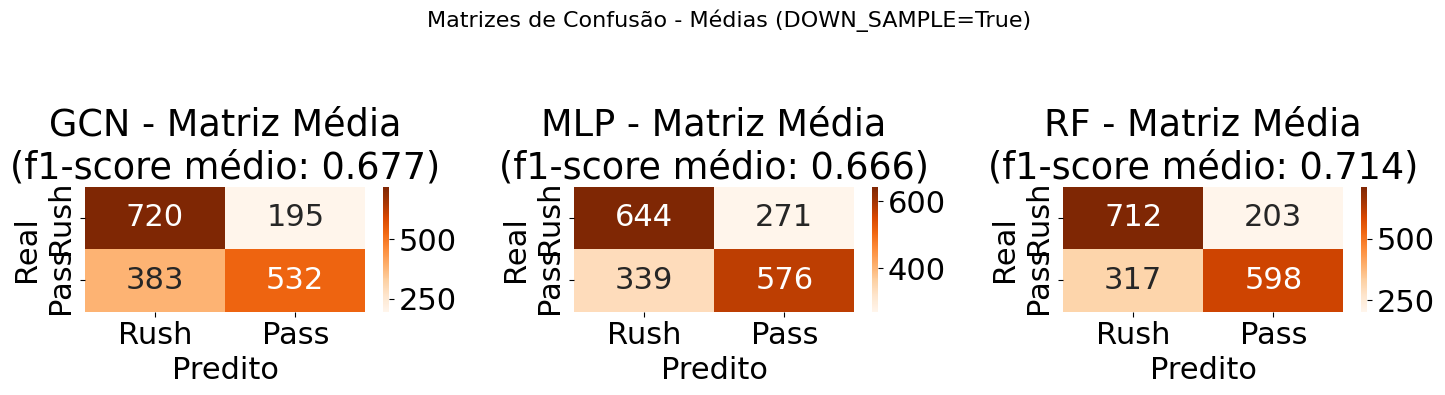

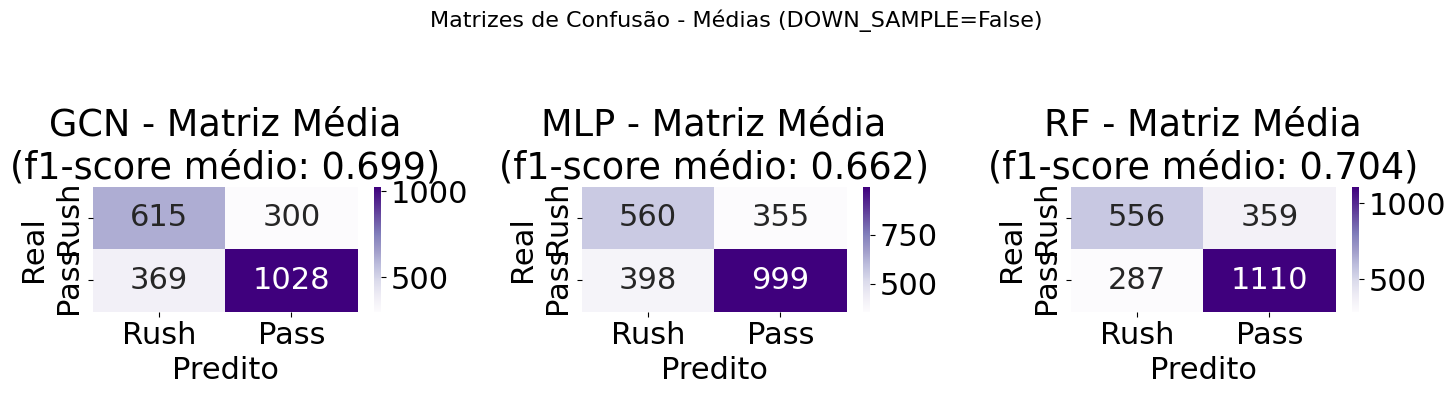

In [43]:
# Visualização das matrizes de confusão médias - DOWN_SAMPLE=True
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
models = ['GCN', 'MLP', 'RF']
class_names = ['Rush', 'Pass']

for i, model in enumerate(models):
    matrix = mean_confusion_matrices_true[model]
    
    # Criar heatmap
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Oranges', 
                xticklabels=class_names, yticklabels=class_names,
                ax=axes[i], cbar=True)
    
    # Calcular média do f1-score para DOWN_SAMPLE=True
    if len(df_downsample_true) > 0:
        mean_f1 = df_downsample_true[f'{model}_MACRO_F1'].mean()
        axes[i].set_title(f'{model} - Matriz Média\n(f1-score médio: {mean_f1:.3f})')
    else:
        axes[i].set_title(f'{model} - Matriz Média\n(Sem dados)')
    
    axes[i].set_xlabel('Predito')
    axes[i].set_ylabel('Real')

plt.suptitle('Matrizes de Confusão - Médias (DOWN_SAMPLE=True)', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

# Visualização das matrizes de confusão médias - DOWN_SAMPLE=False
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, model in enumerate(models):
    matrix = mean_confusion_matrices_false[model]
    
    # Criar heatmap
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Purples', 
                xticklabels=class_names, yticklabels=class_names,
                ax=axes[i], cbar=True)
    
    # Calcular média do f1-score para DOWN_SAMPLE=False
    if len(df_downsample_false) > 0:
        mean_f1 = df_downsample_false[f'{model}_MACRO_F1'].mean()
        axes[i].set_title(f'{model} - Matriz Média\n(f1-score médio: {mean_f1:.3f})')
    else:
        axes[i].set_title(f'{model} - Matriz Média\n(Sem dados)')
    
    axes[i].set_xlabel('Predito')
    axes[i].set_ylabel('Real')

plt.suptitle('Matrizes de Confusão - Médias (DOWN_SAMPLE=False)', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

Teste de Friedman: Estatística=8.3333, p-valor=0.0155

Ranks Médios:
MODEL
RF     1.166667
GCN    2.000000
MLP    2.833333
dtype: float64

Tabela de p-valores (Teste de Nemenyi):
MODEL     GCN     MLP      RF
MODEL                        
GCN    1.0000  0.3186  0.3186
MLP    0.3186  1.0000  0.0109
RF     0.3186  0.0109  1.0000


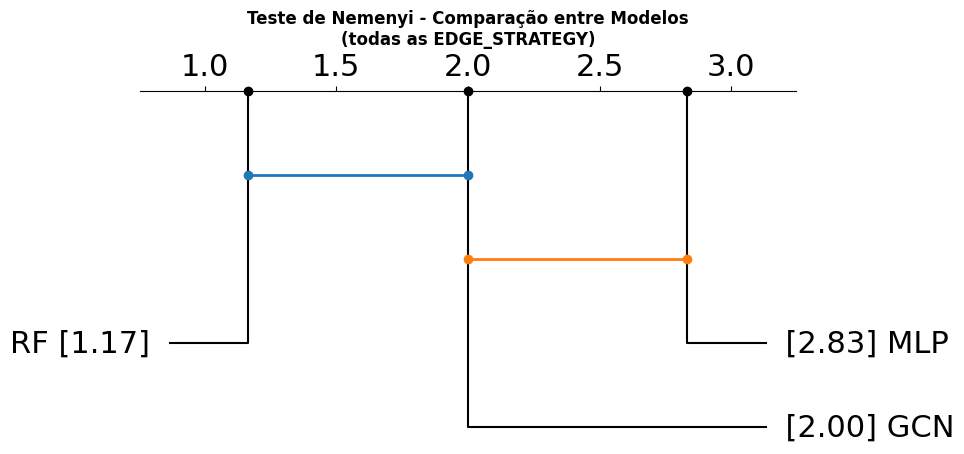

In [44]:
# Teste 1: Comparação entre modelos para todas as EDGE_STRATEGY
df_test1 = df.copy()

# Função para extrair o macro avg f1-score de cada modelo
def extract_macro_f1(results):
    if isinstance(results, dict) and 'macro avg' in results and 'f1-score' in results['macro avg']:
        return results['macro avg']['f1-score']
    return np.nan

# Adicionar a coluna MACRO_F1_SCORE para cada modelo
for model in ['GCN', 'MLP', 'RF']:
    df_test1[f'{model}_MACRO_F1'] = df_test1[f'{model}_RESULTS'].apply(extract_macro_f1)

# Transformar o dataframe para o formato "melted"
df_melted = df_test1.melt(
    id_vars=['EDGE_STRATEGY', 'RANDOM_SEED', 'DOWN_SAMPLE', 'QB_LINK', 'N'],
    value_vars=['GCN_MACRO_F1', 'MLP_MACRO_F1', 'RF_MACRO_F1'],
    var_name='MODEL',
    value_name='MACRO_F1_SCORE'
)

# Ajustar os nomes dos modelos
df_melted['MODEL'] = df_melted['MODEL'].str.replace('_MACRO_F1', '')

# Preparar os dados para o teste
pivot_table = df_melted.pivot_table(index='EDGE_STRATEGY', columns='MODEL', values='MACRO_F1_SCORE')
pivot_table.dropna(inplace=True)

# Teste de Friedman
stat, p_value = friedmanchisquare(*[pivot_table[col] for col in pivot_table.columns])
print(f"Teste de Friedman: Estatística={stat:.4f}, p-valor={p_value:.4g}")

# Ranks médios
mean_ranks = pivot_table.rank(axis=1, ascending=False).mean().sort_values()
print(f"\nRanks Médios:\n{mean_ranks}")

# Plotar resultado
fig, ax = plt.subplots(figsize=(10, 5))

if p_value < 0.05:
    nemenyi_results = sp.posthoc_nemenyi_friedman(pivot_table.to_numpy())
    nemenyi_results.columns = pivot_table.columns
    nemenyi_results.index = pivot_table.columns
    print("\nTabela de p-valores (Teste de Nemenyi):")
    print(nemenyi_results.round(4))
    
    sp.critical_difference_diagram(
        ranks=mean_ranks,
        sig_matrix=nemenyi_results,
        label_fmt_left='{label} [{rank:.2f}]  ',
        label_fmt_right='  [{rank:.2f}] {label}',
        text_h_margin=0.3,
        crossbar_props={'color': None, 'marker': 'o'},
        elbow_props={'color': 'black'},
        ax=ax
    )
    ax.set_title('Teste de Nemenyi - Comparação entre Modelos\n(todas as EDGE_STRATEGY)', fontsize=12, fontweight='bold')
else:
    ax.text(0.5, 0.5, f"Teste de Friedman não mostrou diferença significativa\n(p={p_value:.3f})",
            ha='center', va='center', fontsize=12)
    ax.axis('off')

plt.tight_layout()
plt.savefig('nemenyi_test1_modelos_todas_edge_strategy.pdf', format='pdf')
plt.show()


=== DOWN_SAMPLE=True ===
Teste de Friedman: Estatística=6.3333, p-valor=0.04214
Ranks Médios:
MODEL
RF     1.166667
GCN    2.333333
MLP    2.500000
dtype: float64

Tabela de p-valores (Teste de Nemenyi):
MODEL     GCN     MLP      RF
MODEL                        
GCN    1.0000  0.9551  0.1072
MLP    0.9551  1.0000  0.0545
RF     0.1072  0.0545  1.0000

=== DOWN_SAMPLE=False ===
Teste de Friedman: Estatística=9.0000, p-valor=0.01111
Ranks Médios:
MODEL
GCN    1.5
RF     1.5
MLP    3.0
dtype: float64

Tabela de p-valores (Teste de Nemenyi):
MODEL     GCN     MLP      RF
MODEL                        
GCN    1.0000  0.0254  1.0000
MLP    0.0254  1.0000  0.0254
RF     1.0000  0.0254  1.0000


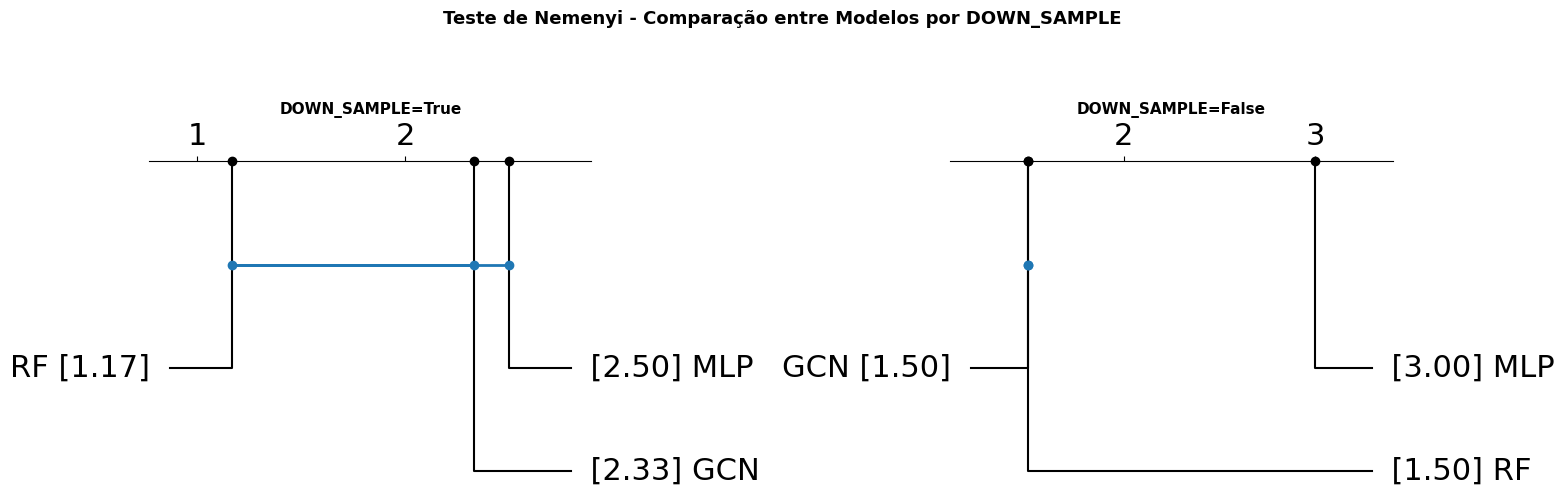

In [45]:
# Teste 2: Comparação entre modelos por DOWN_SAMPLE
df_test2 = df.copy()

def extract_macro_f1(results):
    if isinstance(results, dict) and 'macro avg' in results and 'f1-score' in results['macro avg']:
        return results['macro avg']['f1-score']
    return np.nan

for model in ['GCN', 'MLP', 'RF']:
    df_test2[f'{model}_MACRO_F1'] = df_test2[f'{model}_RESULTS'].apply(extract_macro_f1)

# Separar por DOWN_SAMPLE
down_sample_values = [True, False]
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

for idx, down_sample in enumerate(down_sample_values):
    df_filtered = df_test2[df_test2['DOWN_SAMPLE'] == down_sample]
    
    df_melted = df_filtered.melt(
        id_vars=['EDGE_STRATEGY', 'RANDOM_SEED', 'QB_LINK', 'N'],
        value_vars=['GCN_MACRO_F1', 'MLP_MACRO_F1', 'RF_MACRO_F1'],
        var_name='MODEL',
        value_name='MACRO_F1_SCORE'
    )
    
    df_melted['MODEL'] = df_melted['MODEL'].str.replace('_MACRO_F1', '')
    
    pivot_table = df_melted.pivot_table(index='EDGE_STRATEGY', columns='MODEL', values='MACRO_F1_SCORE')
    pivot_table.dropna(inplace=True)
    
    stat, p_value = friedmanchisquare(*[pivot_table[col] for col in pivot_table.columns])
    print(f"\n=== DOWN_SAMPLE={down_sample} ===")
    print(f"Teste de Friedman: Estatística={stat:.4f}, p-valor={p_value:.4g}")
    
    mean_ranks = pivot_table.rank(axis=1, ascending=False).mean().sort_values()
    print(f"Ranks Médios:\n{mean_ranks}")
    
    ax = axes[idx]
    
    if p_value < 0.05:
        nemenyi_results = sp.posthoc_nemenyi_friedman(pivot_table.to_numpy())
        nemenyi_results.columns = pivot_table.columns
        nemenyi_results.index = pivot_table.columns
        print(f"\nTabela de p-valores (Teste de Nemenyi):")
        print(nemenyi_results.round(4))
        
        sp.critical_difference_diagram(
            ranks=mean_ranks,
            sig_matrix=nemenyi_results,
            label_fmt_left='{label} [{rank:.2f}]  ',
            label_fmt_right='  [{rank:.2f}] {label}',
            text_h_margin=0.3,
            crossbar_props={'color': None, 'marker': 'o'},
            elbow_props={'color': 'black'},
            ax=ax
        )
        ax.set_title(f'DOWN_SAMPLE={down_sample}', fontsize=11, fontweight='bold')
    else:
        ax.text(0.5, 0.5, f"Sem diferença significativa\n(p={p_value:.3f})",
                ha='center', va='center', fontsize=11)
        ax.axis('off')

fig.suptitle('Teste de Nemenyi - Comparação entre Modelos por DOWN_SAMPLE', fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('nemenyi_test2_modelos_por_down_sample.pdf', format='pdf')
plt.show()


=== QB_LINK=True ===
Teste de Friedman: Estatística=6.3333, p-valor=0.04214
Ranks Médios:
MODEL
RF     1.166667
MLP    2.333333
GCN    2.500000
dtype: float64

Tabela de p-valores (Teste de Nemenyi):
MODEL     GCN     MLP      RF
MODEL                        
GCN    1.0000  0.9551  0.0545
MLP    0.9551  1.0000  0.1072
RF     0.0545  0.1072  1.0000

=== QB_LINK=False ===
Teste de Friedman: Estatística=9.0000, p-valor=0.01111
Ranks Médios:
MODEL
GCN    1.5
RF     1.5
MLP    3.0
dtype: float64

Tabela de p-valores (Teste de Nemenyi):
MODEL     GCN     MLP      RF
MODEL                        
GCN    1.0000  0.0254  1.0000
MLP    0.0254  1.0000  0.0254
RF     1.0000  0.0254  1.0000


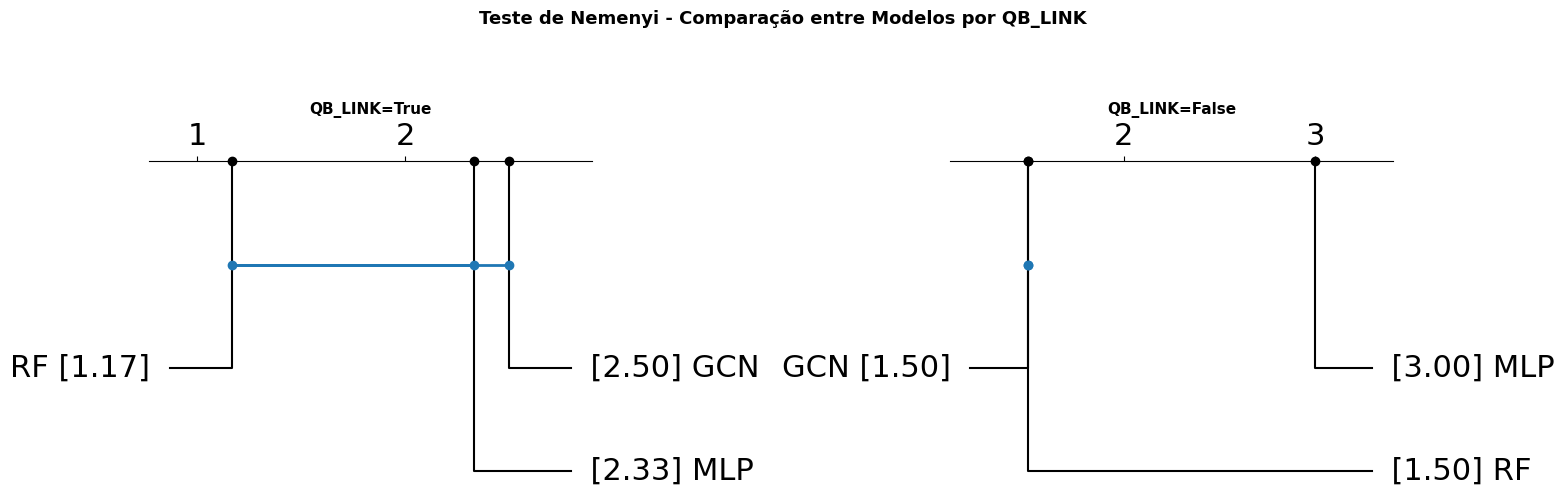

In [46]:
# Teste 3: Comparação entre modelos por QB_LINK
df_test3 = df.copy()

def extract_macro_f1(results):
    if isinstance(results, dict) and 'macro avg' in results and 'f1-score' in results['macro avg']:
        return results['macro avg']['f1-score']
    return np.nan

for model in ['GCN', 'MLP', 'RF']:
    df_test3[f'{model}_MACRO_F1'] = df_test3[f'{model}_RESULTS'].apply(extract_macro_f1)

# Separar por QB_LINK
qb_link_values = [True, False]
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

for idx, qb_link in enumerate(qb_link_values):
    df_filtered = df_test3[df_test3['QB_LINK'] == qb_link]
    
    df_melted = df_filtered.melt(
        id_vars=['EDGE_STRATEGY', 'RANDOM_SEED', 'DOWN_SAMPLE', 'N'],
        value_vars=['GCN_MACRO_F1', 'MLP_MACRO_F1', 'RF_MACRO_F1'],
        var_name='MODEL',
        value_name='MACRO_F1_SCORE'
    )
    
    df_melted['MODEL'] = df_melted['MODEL'].str.replace('_MACRO_F1', '')
    
    pivot_table = df_melted.pivot_table(index='EDGE_STRATEGY', columns='MODEL', values='MACRO_F1_SCORE')
    pivot_table.dropna(inplace=True)
    
    stat, p_value = friedmanchisquare(*[pivot_table[col] for col in pivot_table.columns])
    print(f"\n=== QB_LINK={qb_link} ===")
    print(f"Teste de Friedman: Estatística={stat:.4f}, p-valor={p_value:.4g}")
    
    mean_ranks = pivot_table.rank(axis=1, ascending=False).mean().sort_values()
    print(f"Ranks Médios:\n{mean_ranks}")
    
    ax = axes[idx]
    
    if p_value < 0.05:
        nemenyi_results = sp.posthoc_nemenyi_friedman(pivot_table.to_numpy())
        nemenyi_results.columns = pivot_table.columns
        nemenyi_results.index = pivot_table.columns
        print(f"\nTabela de p-valores (Teste de Nemenyi):")
        print(nemenyi_results.round(4))
        
        sp.critical_difference_diagram(
            ranks=mean_ranks,
            sig_matrix=nemenyi_results,
            label_fmt_left='{label} [{rank:.2f}]  ',
            label_fmt_right='  [{rank:.2f}] {label}',
            text_h_margin=0.3,
            crossbar_props={'color': None, 'marker': 'o'},
            elbow_props={'color': 'black'},
            ax=ax
        )
        ax.set_title(f'QB_LINK={qb_link}', fontsize=11, fontweight='bold')
    else:
        ax.text(0.5, 0.5, f"Sem diferença significativa\n(p={p_value:.3f})",
                ha='center', va='center', fontsize=11)
        ax.axis('off')

fig.suptitle('Teste de Nemenyi - Comparação entre Modelos por QB_LINK', fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('nemenyi_test3_modelos_por_qb_link.pdf', format='pdf')
plt.show()


=== Modelo: GCN ===
Teste de Friedman: Estatística=65.6714, p-valor=8.132e-13
Ranks Médios:
EDGE_STRATEGY
CLOSEST-       2.200
MST            2.675
RNG            3.200
QB-CLOSEST-    3.525
GABRIEL        4.250
DELAUNAY       5.150
dtype: float64

Tabela de p-valores (Teste de Nemenyi):
EDGE_STRATEGY  CLOSEST-  DELAUNAY  GABRIEL     MST  QB-CLOSEST-     RNG
EDGE_STRATEGY                                                          
CLOSEST-         1.0000    0.0000   0.0000  0.8667       0.0192  0.1594
DELAUNAY         0.0000    1.0000   0.2610  0.0000       0.0014  0.0000
GABRIEL          0.0000    0.2610   1.0000  0.0023       0.5097  0.1211
MST              0.8667    0.0000   0.0023  1.0000       0.3241  0.8094
QB-CLOSEST-      0.0192    0.0014   0.5097  0.3241       1.0000  0.9715
RNG              0.1594    0.0000   0.1211  0.8094       0.9715  1.0000

=== Modelo: MLP ===
Teste de Friedman: Estatística=1.6000, p-valor=0.9012
Ranks Médios:
EDGE_STRATEGY
RNG            3.25
QB-CLOSEST- 

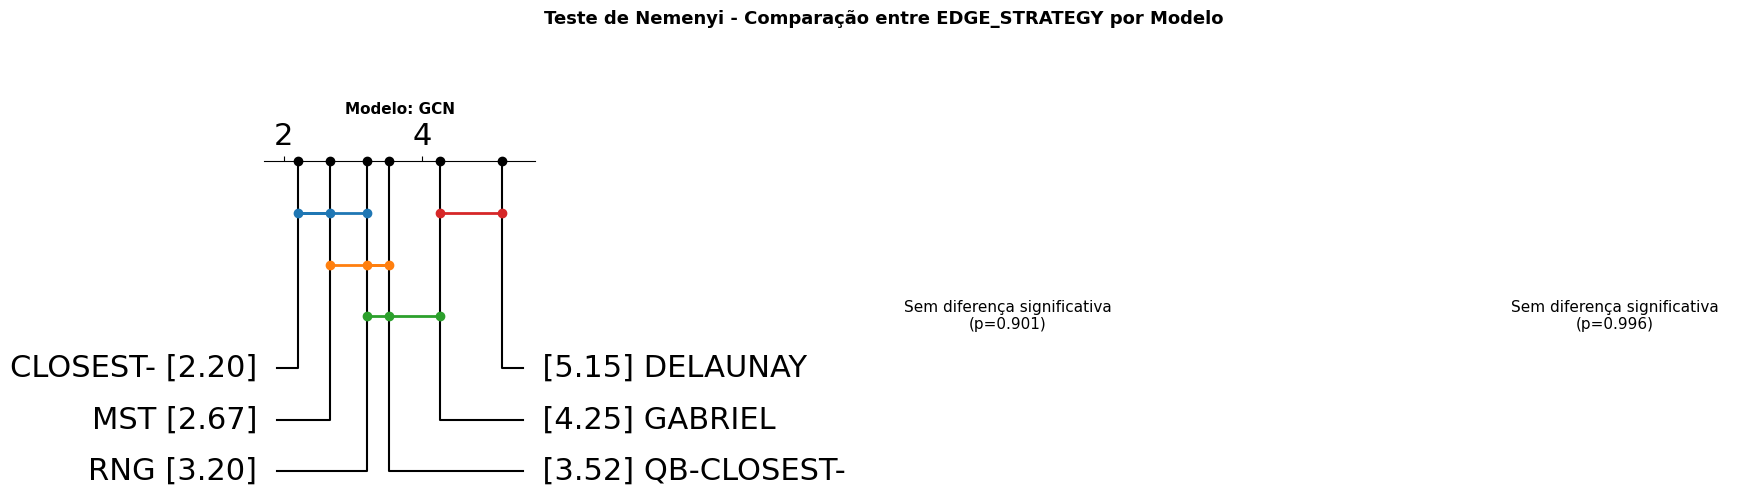

In [47]:
# Teste 4: Comparação entre EDGE_STRATEGY para cada modelo
df_test4 = df.copy()

def extract_macro_f1(results):
    if isinstance(results, dict) and 'macro avg' in results and 'f1-score' in results['macro avg']:
        return results['macro avg']['f1-score']
    return np.nan

for model in ['GCN', 'MLP', 'RF']:
    df_test4[f'{model}_MACRO_F1'] = df_test4[f'{model}_RESULTS'].apply(extract_macro_f1)

# Separar por modelo
models = ['GCN', 'MLP', 'RF']
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, model in enumerate(models):
    df_melted = df_test4.melt(
        id_vars=['EDGE_STRATEGY', 'RANDOM_SEED', 'DOWN_SAMPLE', 'QB_LINK', 'N'],
        value_vars=[f'{model}_MACRO_F1'],
        var_name='EDGE_STRATEGY_COMPARE',
        value_name='MACRO_F1_SCORE'
    )
    
    pivot_table = df_test4.pivot_table(index=['RANDOM_SEED', 'DOWN_SAMPLE', 'QB_LINK', 'N'], 
                                        columns='EDGE_STRATEGY', 
                                        values=f'{model}_MACRO_F1')
    pivot_table.dropna(inplace=True)
    
    stat, p_value = friedmanchisquare(*[pivot_table[col] for col in pivot_table.columns])
    print(f"\n=== Modelo: {model} ===")
    print(f"Teste de Friedman: Estatística={stat:.4f}, p-valor={p_value:.4g}")
    
    mean_ranks = pivot_table.rank(axis=1, ascending=False).mean().sort_values()
    print(f"Ranks Médios:\n{mean_ranks}")
    
    ax = axes[idx]
    
    if p_value < 0.05:
        nemenyi_results = sp.posthoc_nemenyi_friedman(pivot_table.to_numpy())
        nemenyi_results.columns = pivot_table.columns
        nemenyi_results.index = pivot_table.columns
        print(f"\nTabela de p-valores (Teste de Nemenyi):")
        print(nemenyi_results.round(4))
        
        sp.critical_difference_diagram(
            ranks=mean_ranks,
            sig_matrix=nemenyi_results,
            label_fmt_left='{label} [{rank:.2f}]  ',
            label_fmt_right='  [{rank:.2f}] {label}',
            text_h_margin=0.3,
            crossbar_props={'color': None, 'marker': 'o'},
            elbow_props={'color': 'black'},
            ax=ax
        )
        ax.set_title(f'Modelo: {model}', fontsize=11, fontweight='bold')
    else:
        ax.text(0.5, 0.5, f"Sem diferença significativa\n(p={p_value:.3f})",
                ha='center', va='center', fontsize=11)
        ax.axis('off')

fig.suptitle('Teste de Nemenyi - Comparação entre EDGE_STRATEGY por Modelo', fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('nemenyi_test4_edge_strategy_por_modelo.pdf', format='pdf')
plt.show()

Teste de Friedman (DOWN_SAMPLE=True): Estatística=107.4667, p-valor=4.612e-24

Ranks Médios:
MODEL
RF     1.300000
GCN    2.066667
MLP    2.633333
dtype: float64

Tabela de p-valores (Teste de Nemenyi):
MODEL  GCN  MLP   RF
MODEL               
GCN    1.0  0.0  0.0
MLP    0.0  1.0  0.0
RF     0.0  0.0  1.0


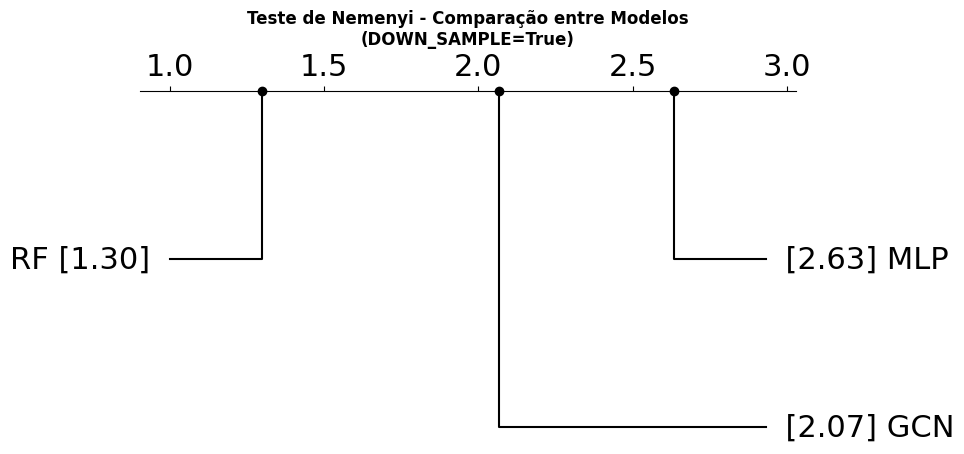

In [48]:
# Teste 5: Comparação entre modelos GCN vs MLP vs RF para DOWN_SAMPLE=True apenas
df_test5 = df[df['DOWN_SAMPLE'] == True].copy()

def extract_macro_f1(results):
    if isinstance(results, dict) and 'macro avg' in results and 'f1-score' in results['macro avg']:
        return results['macro avg']['f1-score']
    return np.nan

for model in ['GCN', 'MLP', 'RF']:
    df_test5[f'{model}_MACRO_F1'] = df_test5[f'{model}_RESULTS'].apply(extract_macro_f1)

df_melted = df_test5.melt(
    id_vars=['EDGE_STRATEGY', 'RANDOM_SEED', 'QB_LINK', 'N'],
    value_vars=['GCN_MACRO_F1', 'MLP_MACRO_F1', 'RF_MACRO_F1'],
    var_name='MODEL',
    value_name='MACRO_F1_SCORE'
)

df_melted['MODEL'] = df_melted['MODEL'].str.replace('_MACRO_F1', '')

pivot_table = df_melted.pivot_table(index=['EDGE_STRATEGY', 'RANDOM_SEED', 'QB_LINK', 'N'], 
                                     columns='MODEL', 
                                     values='MACRO_F1_SCORE')
pivot_table.dropna(inplace=True)

stat, p_value = friedmanchisquare(*[pivot_table[col] for col in pivot_table.columns])
print(f"Teste de Friedman (DOWN_SAMPLE=True): Estatística={stat:.4f}, p-valor={p_value:.4g}")

mean_ranks = pivot_table.rank(axis=1, ascending=False).mean().sort_values()
print(f"\nRanks Médios:\n{mean_ranks}")

fig, ax = plt.subplots(figsize=(10, 5))

if p_value < 0.05:
    nemenyi_results = sp.posthoc_nemenyi_friedman(pivot_table.to_numpy())
    nemenyi_results.columns = pivot_table.columns
    nemenyi_results.index = pivot_table.columns
    print(f"\nTabela de p-valores (Teste de Nemenyi):")
    print(nemenyi_results.round(4))
    
    sp.critical_difference_diagram(
        ranks=mean_ranks,
        sig_matrix=nemenyi_results,
        label_fmt_left='{label} [{rank:.2f}]  ',
        label_fmt_right='  [{rank:.2f}] {label}',
        text_h_margin=0.3,
        crossbar_props={'color': None, 'marker': 'o'},
        elbow_props={'color': 'black'},
        ax=ax
    )
    ax.set_title('Teste de Nemenyi - Comparação entre Modelos\n(DOWN_SAMPLE=True)', fontsize=12, fontweight='bold')
else:
    ax.text(0.5, 0.5, f"Teste de Friedman não mostrou diferença significativa\n(p={p_value:.3f})",
            ha='center', va='center', fontsize=12)
    ax.axis('off')

plt.tight_layout()
plt.savefig('nemenyi_test5_modelos_down_sample_true.pdf', format='pdf')
plt.show()

Teste de Friedman (DOWN_SAMPLE=False): Estatística=113.8167, p-valor=1.928e-25

Ranks Médios:
MODEL
RF     1.458333
GCN    1.766667
MLP    2.775000
dtype: float64

Tabela de p-valores (Teste de Nemenyi):
MODEL     GCN  MLP      RF
MODEL                     
GCN    1.0000  0.0  0.0446
MLP    0.0000  1.0  0.0000
RF     0.0446  0.0  1.0000


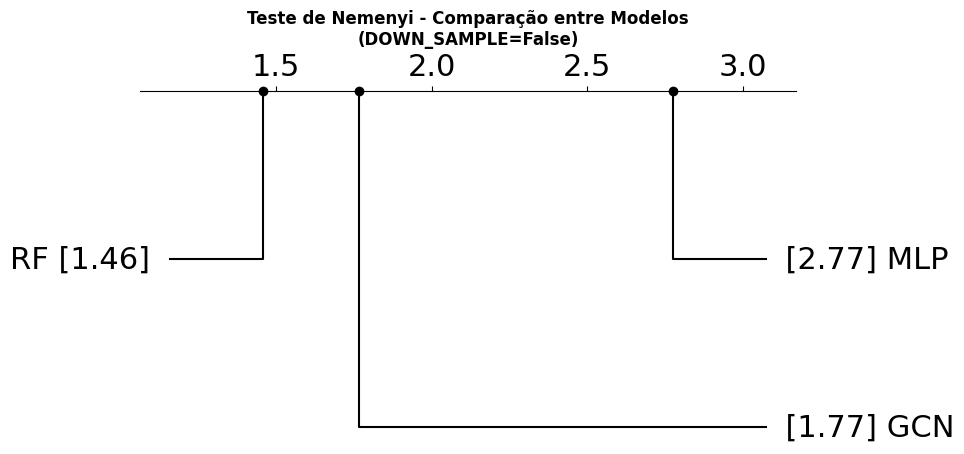

In [49]:
# Teste 6: Comparação entre modelos GCN vs MLP vs RF para DOWN_SAMPLE=False apenas
df_test6 = df[df['DOWN_SAMPLE'] == False].copy()

def extract_macro_f1(results):
    if isinstance(results, dict) and 'macro avg' in results and 'f1-score' in results['macro avg']:
        return results['macro avg']['f1-score']
    return np.nan

for model in ['GCN', 'MLP', 'RF']:
    df_test6[f'{model}_MACRO_F1'] = df_test6[f'{model}_RESULTS'].apply(extract_macro_f1)

df_melted = df_test6.melt(
    id_vars=['EDGE_STRATEGY', 'RANDOM_SEED', 'QB_LINK', 'N'],
    value_vars=['GCN_MACRO_F1', 'MLP_MACRO_F1', 'RF_MACRO_F1'],
    var_name='MODEL',
    value_name='MACRO_F1_SCORE'
)

df_melted['MODEL'] = df_melted['MODEL'].str.replace('_MACRO_F1', '')

pivot_table = df_melted.pivot_table(index=['EDGE_STRATEGY', 'RANDOM_SEED', 'QB_LINK', 'N'], 
                                     columns='MODEL', 
                                     values='MACRO_F1_SCORE')
pivot_table.dropna(inplace=True)

stat, p_value = friedmanchisquare(*[pivot_table[col] for col in pivot_table.columns])
print(f"Teste de Friedman (DOWN_SAMPLE=False): Estatística={stat:.4f}, p-valor={p_value:.4g}")

mean_ranks = pivot_table.rank(axis=1, ascending=False).mean().sort_values()
print(f"\nRanks Médios:\n{mean_ranks}")

fig, ax = plt.subplots(figsize=(10, 5))

if p_value < 0.05:
    nemenyi_results = sp.posthoc_nemenyi_friedman(pivot_table.to_numpy())
    nemenyi_results.columns = pivot_table.columns
    nemenyi_results.index = pivot_table.columns
    print(f"\nTabela de p-valores (Teste de Nemenyi):")
    print(nemenyi_results.round(4))
    
    sp.critical_difference_diagram(
        ranks=mean_ranks,
        sig_matrix=nemenyi_results,
        label_fmt_left='{label} [{rank:.2f}]  ',
        label_fmt_right='  [{rank:.2f}] {label}',
        text_h_margin=0.3,
        crossbar_props={'color': None, 'marker': 'o'},
        elbow_props={'color': 'black'},
        ax=ax
    )
    ax.set_title('Teste de Nemenyi - Comparação entre Modelos\n(DOWN_SAMPLE=False)', fontsize=12, fontweight='bold')
else:
    ax.text(0.5, 0.5, f"Teste de Friedman não mostrou diferença significativa\n(p={p_value:.3f})",
            ha='center', va='center', fontsize=12)
    ax.axis('off')

plt.tight_layout()
plt.savefig('nemenyi_test6_modelos_down_sample_false.pdf', format='pdf')
plt.show()


EDGE_STRATEGY: CLOSEST-

--- Overall ---
Teste de Friedman: Estatística=18.2000, p-valor=0.0001117
Amostras: 10
Ranks Médios:
MODEL
GCN    1.1
RF     1.9
MLP    3.0
dtype: float64
p-valores (Teste de Nemenyi):
MODEL     GCN     MLP      RF
MODEL                        
GCN    1.0000  0.0001  0.1733
MLP    0.0001  1.0000  0.0370
RF     0.1733  0.0370  1.0000

--- QB_LINK=True, DOWN_SAMPLE=True ---
Teste de Friedman: Estatística=16.8000, p-valor=0.0002249
Amostras: 10
Ranks Médios:
MODEL
GCN    1.2
RF     1.8
MLP    3.0
dtype: float64
p-valores (Teste de Nemenyi):
MODEL     GCN     MLP      RF
MODEL                        
GCN    1.0000  0.0002  0.3721
MLP    0.0002  1.0000  0.0199
RF     0.3721  0.0199  1.0000

--- QB_LINK=True, DOWN_SAMPLE=False ---
Teste de Friedman: Estatística=18.2000, p-valor=0.0001117
Amostras: 10
Ranks Médios:
MODEL
GCN    1.1
RF     1.9
MLP    3.0
dtype: float64
p-valores (Teste de Nemenyi):
MODEL     GCN     MLP      RF
MODEL                        
GCN    1.0

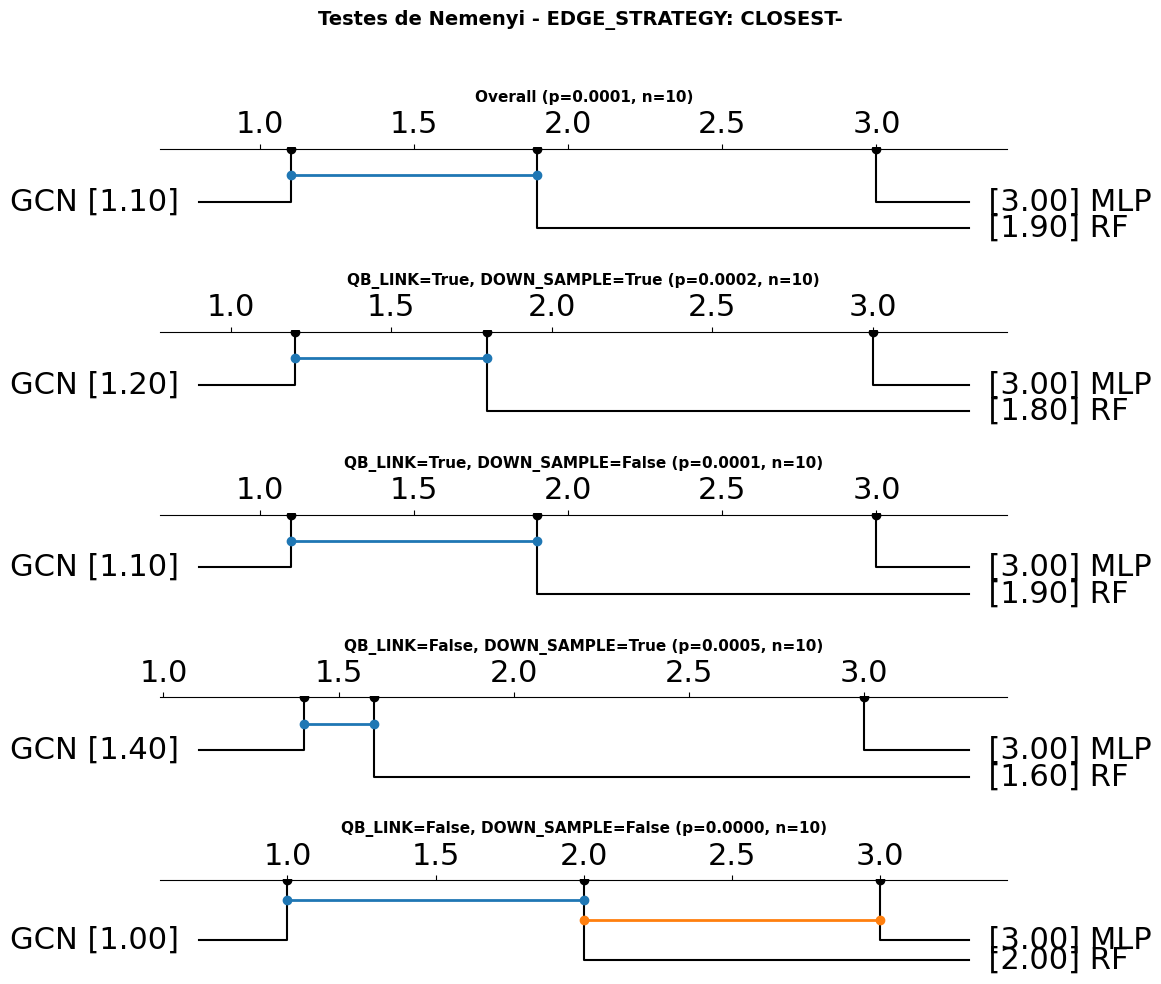


EDGE_STRATEGY: DELAUNAY

--- Overall ---
Teste de Friedman: Estatística=15.0000, p-valor=0.0005531
Amostras: 10
Ranks Médios:
MODEL
RF     1.0
GCN    2.5
MLP    2.5
dtype: float64
p-valores (Teste de Nemenyi):
MODEL     GCN     MLP      RF
MODEL                        
GCN    1.0000  1.0000  0.0023
MLP    1.0000  1.0000  0.0023
RF     0.0023  0.0023  1.0000

--- QB_LINK=True, DOWN_SAMPLE=True ---
Teste de Friedman: Estatística=18.2000, p-valor=0.0001117
Amostras: 10
Ranks Médios:
MODEL
RF     1.0
MLP    2.1
GCN    2.9
dtype: float64
p-valores (Teste de Nemenyi):
MODEL     GCN     MLP      RF
MODEL                        
GCN    1.0000  0.1733  0.0001
MLP    0.1733  1.0000  0.0370
RF     0.0001  0.0370  1.0000

--- QB_LINK=True, DOWN_SAMPLE=False ---
Teste de Friedman: Estatística=18.2000, p-valor=0.0001117
Amostras: 10
Ranks Médios:
MODEL
RF     1.0
MLP    2.1
GCN    2.9
dtype: float64
p-valores (Teste de Nemenyi):
MODEL     GCN     MLP      RF
MODEL                        
GCN    1.0

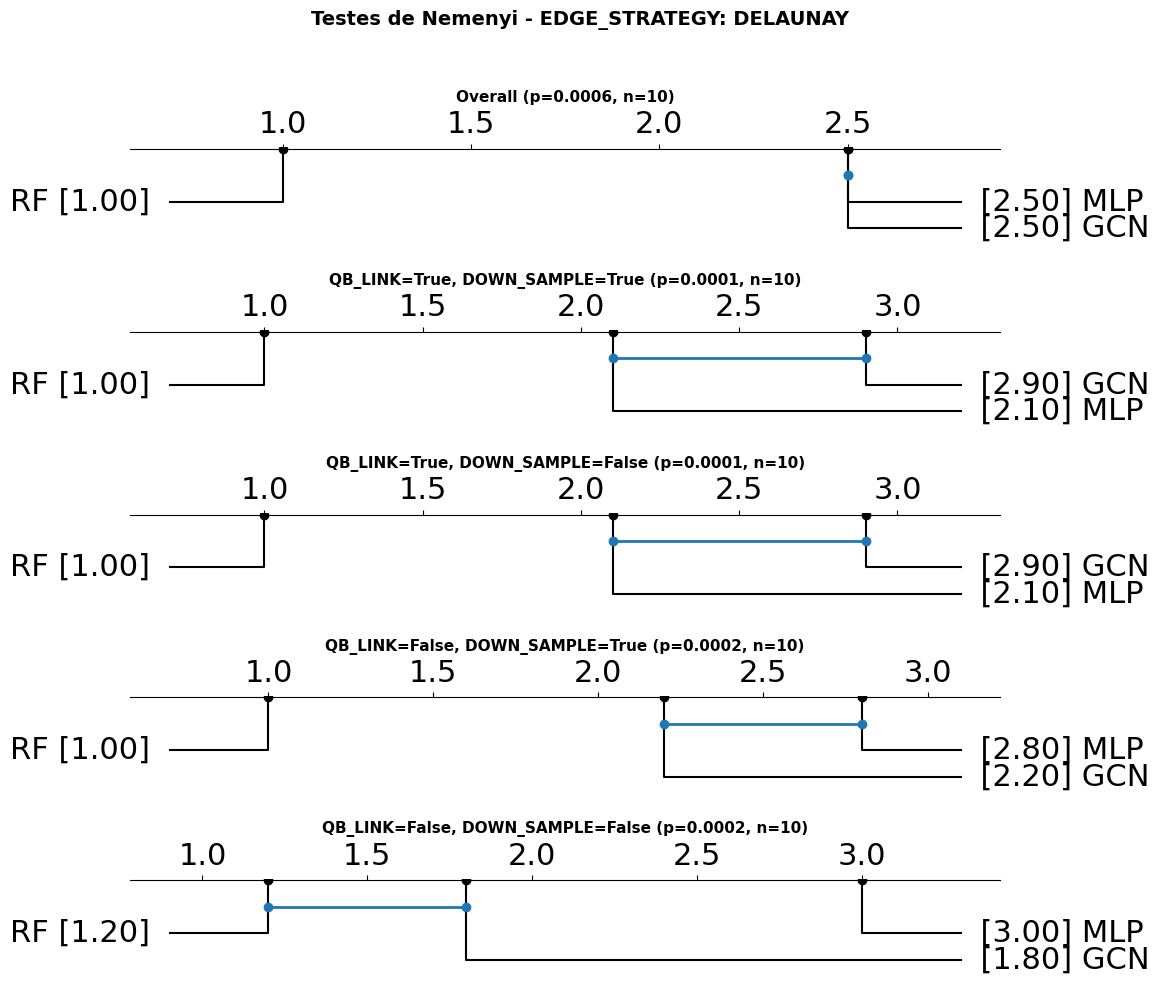


EDGE_STRATEGY: GABRIEL

--- Overall ---
Teste de Friedman: Estatística=15.8000, p-valor=0.0003707
Amostras: 10
Ranks Médios:
MODEL
RF     1.0
GCN    2.3
MLP    2.7
dtype: float64
p-valores (Teste de Nemenyi):
MODEL     GCN     MLP      RF
MODEL                        
GCN    1.0000  0.6438  0.0102
MLP    0.6438  1.0000  0.0004
RF     0.0102  0.0004  1.0000

--- QB_LINK=True, DOWN_SAMPLE=True ---
Teste de Friedman: Estatística=18.2000, p-valor=0.0001117
Amostras: 10
Ranks Médios:
MODEL
RF     1.0
MLP    2.1
GCN    2.9
dtype: float64
p-valores (Teste de Nemenyi):
MODEL     GCN     MLP      RF
MODEL                        
GCN    1.0000  0.1733  0.0001
MLP    0.1733  1.0000  0.0370
RF     0.0001  0.0370  1.0000

--- QB_LINK=True, DOWN_SAMPLE=False ---
Teste de Friedman: Estatística=16.8000, p-valor=0.0002249
Amostras: 10
Ranks Médios:
MODEL
RF     1.0
MLP    2.2
GCN    2.8
dtype: float64
p-valores (Teste de Nemenyi):
MODEL     GCN     MLP      RF
MODEL                        
GCN    1.00

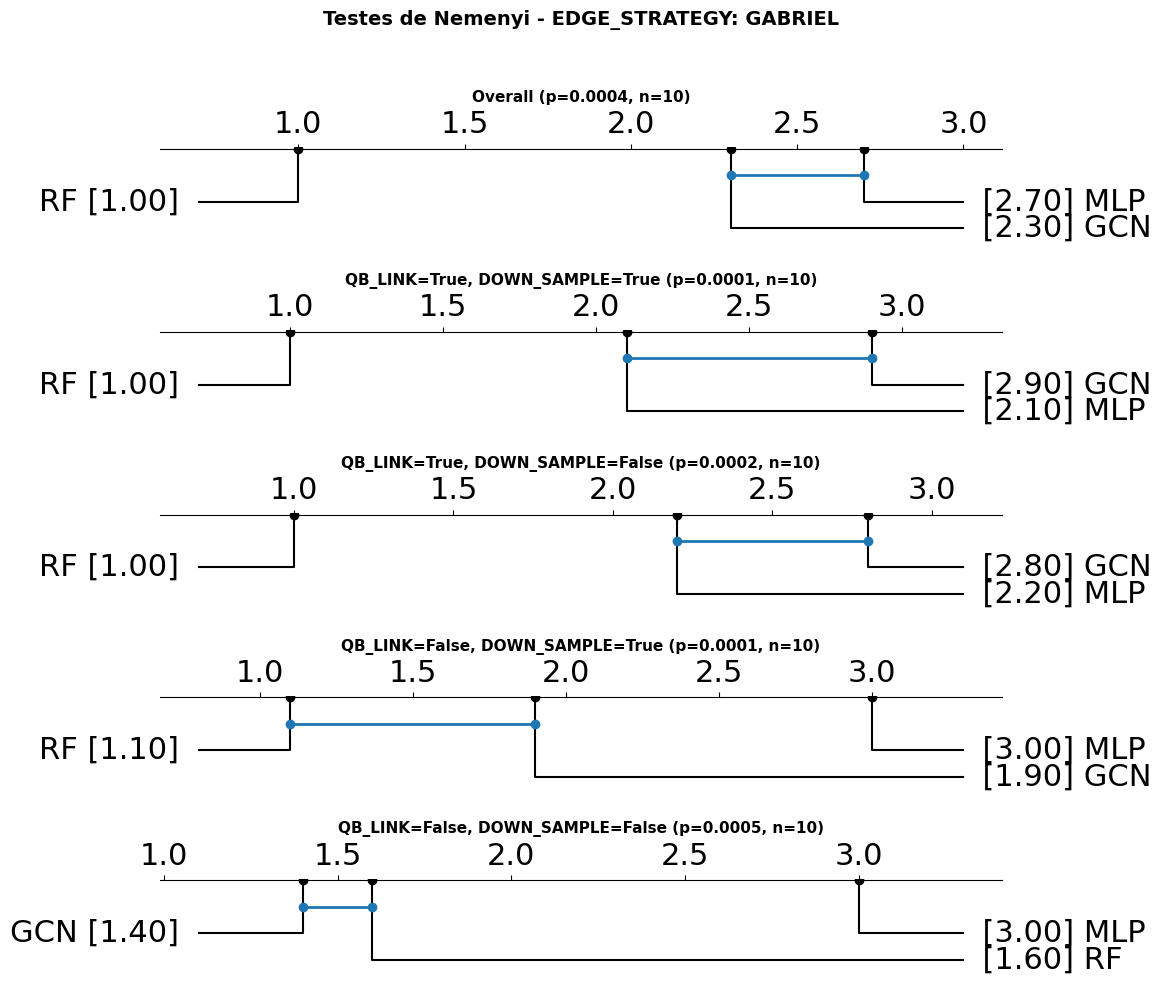


EDGE_STRATEGY: MST

--- Overall ---
Teste de Friedman: Estatística=14.6000, p-valor=0.0006755
Amostras: 10
Ranks Médios:
MODEL
RF     1.2
GCN    1.9
MLP    2.9
dtype: float64
p-valores (Teste de Nemenyi):
MODEL     GCN     MLP      RF
MODEL                        
GCN    1.0000  0.0653  0.2608
MLP    0.0653  1.0000  0.0004
RF     0.2608  0.0004  1.0000

--- QB_LINK=True, DOWN_SAMPLE=True ---
Teste de Friedman: Estatística=20.0000, p-valor=4.54e-05
Amostras: 10
Ranks Médios:
MODEL
RF     1.0
MLP    2.0
GCN    3.0
dtype: float64
p-valores (Teste de Nemenyi):
MODEL     GCN     MLP      RF
MODEL                        
GCN    1.0000  0.0653  0.0000
MLP    0.0653  1.0000  0.0653
RF     0.0000  0.0653  1.0000

--- QB_LINK=True, DOWN_SAMPLE=False ---
Teste de Friedman: Estatística=15.0000, p-valor=0.0005531
Amostras: 10
Ranks Médios:
MODEL
RF     1.0
GCN    2.5
MLP    2.5
dtype: float64
p-valores (Teste de Nemenyi):
MODEL     GCN     MLP      RF
MODEL                        
GCN    1.0000  1

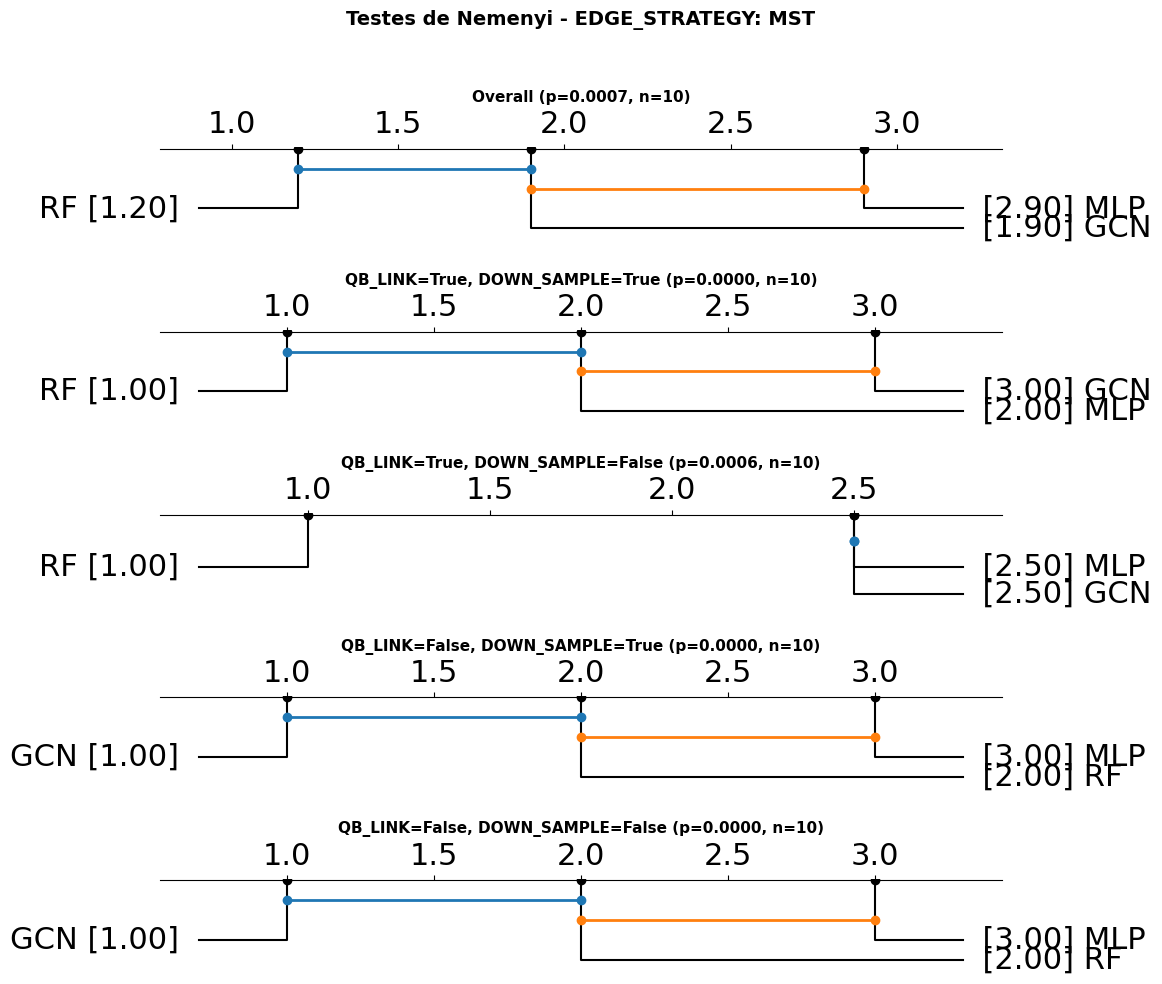


EDGE_STRATEGY: QB-CLOSEST-

--- Overall ---
Teste de Friedman: Estatística=20.0000, p-valor=4.54e-05
Amostras: 10
Ranks Médios:
MODEL
RF     1.0
GCN    2.0
MLP    3.0
dtype: float64
p-valores (Teste de Nemenyi):
MODEL     GCN     MLP      RF
MODEL                        
GCN    1.0000  0.0653  0.0653
MLP    0.0653  1.0000  0.0000
RF     0.0653  0.0000  1.0000

--- QB_LINK=True, DOWN_SAMPLE=True ---
Teste de Friedman: Estatística=15.8000, p-valor=0.0003707
Amostras: 10
Ranks Médios:
MODEL
RF     1.0
GCN    2.3
MLP    2.7
dtype: float64
p-valores (Teste de Nemenyi):
MODEL     GCN     MLP      RF
MODEL                        
GCN    1.0000  0.6438  0.0102
MLP    0.6438  1.0000  0.0004
RF     0.0102  0.0004  1.0000

--- QB_LINK=True, DOWN_SAMPLE=False ---
Teste de Friedman: Estatística=15.8000, p-valor=0.0003707
Amostras: 10
Ranks Médios:
MODEL
RF     1.3
GCN    1.7
MLP    3.0
dtype: float64
p-valores (Teste de Nemenyi):
MODEL     GCN     MLP      RF
MODEL                        
GCN    1

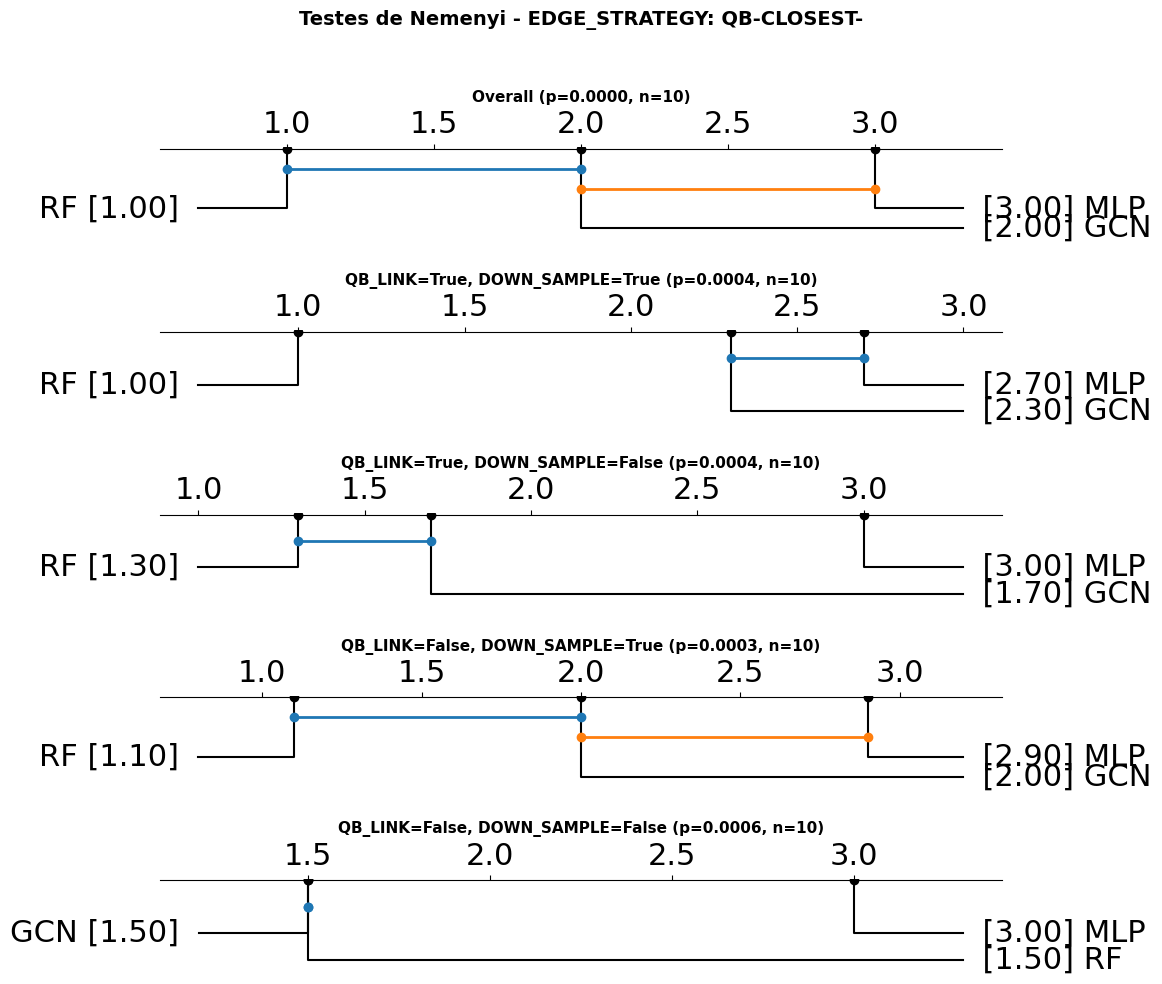


EDGE_STRATEGY: RNG

--- Overall ---
Teste de Friedman: Estatística=16.2000, p-valor=0.0003035
Amostras: 10
Ranks Médios:
MODEL
RF     1.1
GCN    2.0
MLP    2.9
dtype: float64
p-valores (Teste de Nemenyi):
MODEL     GCN     MLP      RF
MODEL                        
GCN    1.0000  0.1092  0.1092
MLP    0.1092  1.0000  0.0002
RF     0.1092  0.0002  1.0000

--- QB_LINK=True, DOWN_SAMPLE=True ---
Teste de Friedman: Estatística=20.0000, p-valor=4.54e-05
Amostras: 10
Ranks Médios:
MODEL
RF     1.0
MLP    2.0
GCN    3.0
dtype: float64
p-valores (Teste de Nemenyi):
MODEL     GCN     MLP      RF
MODEL                        
GCN    1.0000  0.0653  0.0000
MLP    0.0653  1.0000  0.0653
RF     0.0000  0.0653  1.0000

--- QB_LINK=True, DOWN_SAMPLE=False ---
Teste de Friedman: Estatística=15.0000, p-valor=0.0005531
Amostras: 10
Ranks Médios:
MODEL
RF     1.0
GCN    2.5
MLP    2.5
dtype: float64
p-valores (Teste de Nemenyi):
MODEL     GCN     MLP      RF
MODEL                        
GCN    1.0000  1

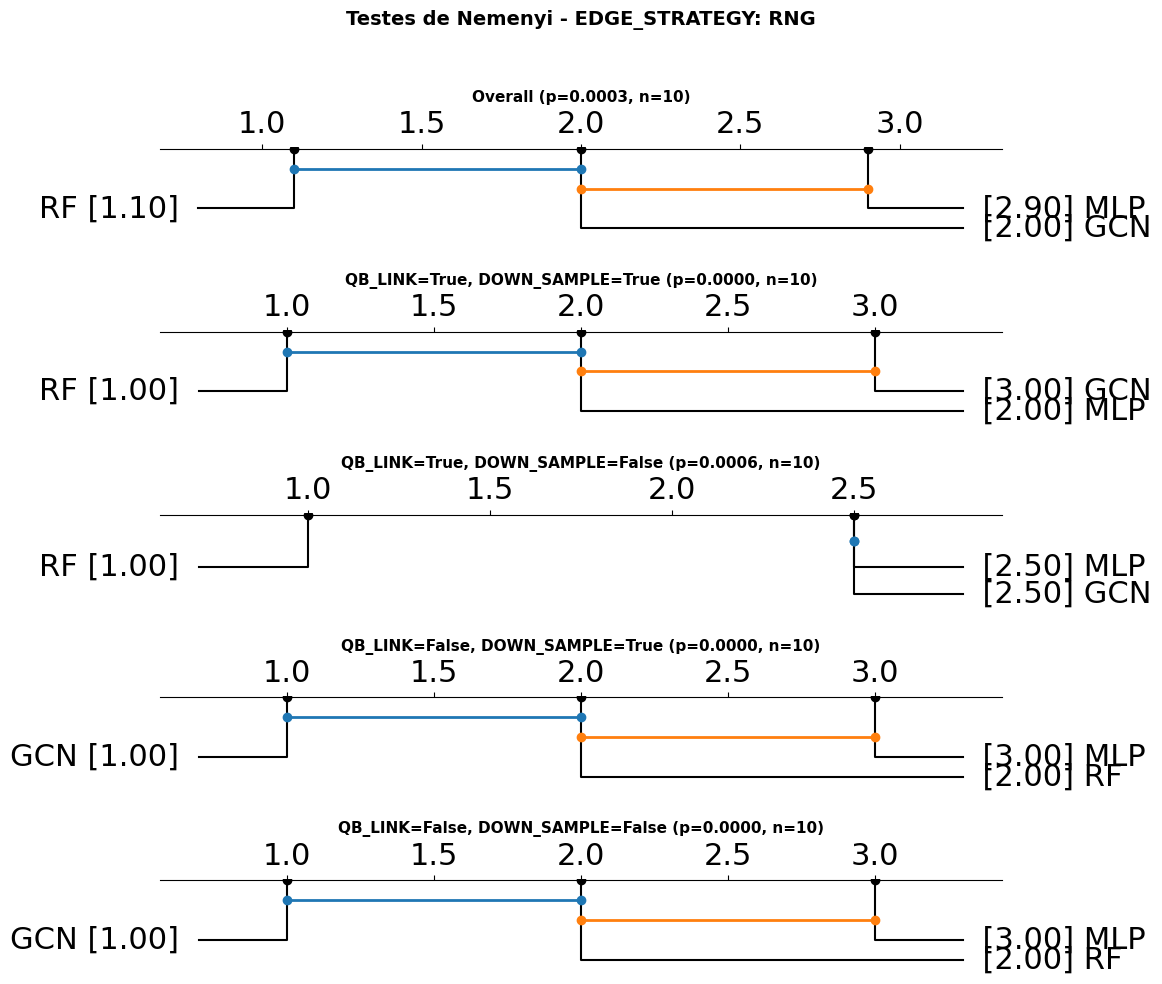

In [50]:
# Testes de Nemenyi por EDGE_STRATEGY com todas as combinações de QB_LINK e DOWN_SAMPLE
df_edge_strategy_tests = df.copy()

def extract_macro_f1(results):
    if isinstance(results, dict) and 'macro avg' in results and 'f1-score' in results['macro avg']:
        return results['macro avg']['f1-score']
    return np.nan

for model in ['GCN', 'MLP', 'RF']:
    df_edge_strategy_tests[f'{model}_MACRO_F1'] = df_edge_strategy_tests[f'{model}_RESULTS'].apply(extract_macro_f1)

# Obter todas as EDGE_STRATEGY únicas
edge_strategies = df_edge_strategy_tests['EDGE_STRATEGY'].unique()

# Para cada EDGE_STRATEGY
for edge_strategy in sorted(edge_strategies):
    print(f"\n{'='*80}")
    print(f"EDGE_STRATEGY: {edge_strategy}")
    print(f"{'='*80}")
    
    df_edge = df_edge_strategy_tests[df_edge_strategy_tests['EDGE_STRATEGY'] == edge_strategy].copy()
    
    # Criar figura com múltiplos subplots (1 overall + 4 combinações de QB_LINK e DOWN_SAMPLE)
    fig, axes = plt.subplots(5, 1, figsize=(12, 10))
    
    test_configs = [
        ('Overall', None, None),
        ('QB_LINK=True, DOWN_SAMPLE=True', True, True),
        ('QB_LINK=True, DOWN_SAMPLE=False', True, False),
        ('QB_LINK=False, DOWN_SAMPLE=True', False, True),
        ('QB_LINK=False, DOWN_SAMPLE=False', False, False)
    ]
    
    for idx, (label, qb_link_filter, down_sample_filter) in enumerate(test_configs):
        print(f"\n--- {label} ---")
        
        # Filtrar dados
        if label == 'Overall':
            df_filtered = df_edge.copy()
        else:
            df_filtered = df_edge[
                (df_edge['QB_LINK'] == qb_link_filter) & 
                (df_edge['DOWN_SAMPLE'] == down_sample_filter)
            ].copy()
        
        if len(df_filtered) == 0:
            print(f"Sem dados para {label}")
            axes[idx].text(0.5, 0.5, f"Sem dados disponíveis\npara {label}",
                          ha='center', va='center', fontsize=11)
            axes[idx].axis('off')
            continue
        
        # Preparar dados para o teste
        df_melted = df_filtered.melt(
            id_vars=['RANDOM_SEED', 'N'],
            value_vars=['GCN_MACRO_F1', 'MLP_MACRO_F1', 'RF_MACRO_F1'],
            var_name='MODEL',
            value_name='MACRO_F1_SCORE'
        )
        
        df_melted['MODEL'] = df_melted['MODEL'].str.replace('_MACRO_F1', '')
        
        pivot_table = df_melted.pivot_table(
            index=['RANDOM_SEED', 'N'], 
            columns='MODEL', 
            values='MACRO_F1_SCORE'
        )
        pivot_table.dropna(inplace=True)
        
        if len(pivot_table) < 2:
            print(f"Dados insuficientes para {label}")
            axes[idx].text(0.5, 0.5, f"Dados insuficientes\npara {label}",
                          ha='center', va='center', fontsize=11)
            axes[idx].axis('off')
            continue
        
        # Teste de Friedman
        stat, p_value = friedmanchisquare(*[pivot_table[col] for col in pivot_table.columns])
        print(f"Teste de Friedman: Estatística={stat:.4f}, p-valor={p_value:.4g}")
        print(f"Amostras: {len(pivot_table)}")
        
        # Ranks médios
        mean_ranks = pivot_table.rank(axis=1, ascending=False).mean().sort_values()
        print(f"Ranks Médios:\n{mean_ranks}")
        
        ax = axes[idx]
        
        if p_value < 0.05:
            nemenyi_results = sp.posthoc_nemenyi_friedman(pivot_table.to_numpy())
            nemenyi_results.columns = pivot_table.columns
            nemenyi_results.index = pivot_table.columns
            print(f"p-valores (Teste de Nemenyi):")
            print(nemenyi_results.round(4))
            
            sp.critical_difference_diagram(
                ranks=mean_ranks,
                sig_matrix=nemenyi_results,
                label_fmt_left='{label} [{rank:.2f}]  ',
                label_fmt_right='  [{rank:.2f}] {label}',
                text_h_margin=0.3,
                crossbar_props={'color': None, 'marker': 'o'},
                elbow_props={'color': 'black', 'linewidth': 1.5},
                ax=ax
            )
            ax.set_title(f'{label} (p={p_value:.4f}, n={len(pivot_table)})', 
                        fontsize=11, fontweight='bold')
            # Ajustar altura das hastes verticais reduzindo o ylim
            ax.set_ylim(ax.get_ylim()[0], ax.get_ylim()[1] * 0.4)
        else:
            ax.text(0.5, 0.5, f'{label}\nSem diferença significativa (p={p_value:.4f})\nn={len(pivot_table)}',
                   ha='center', va='center', fontsize=11)
            ax.axis('off')
    
    fig.suptitle(f'Testes de Nemenyi - EDGE_STRATEGY: {edge_strategy}', 
                fontsize=14, fontweight='bold', y=0.995)
    plt.tight_layout()
    
    # Salvar figura
    filename = f'nemenyi_edge_strategy_{edge_strategy.replace("/", "_")}.pdf'
    plt.savefig(filename, format='pdf', bbox_inches='tight')
    print(f"\nFigura salva: {filename}")
    plt.show()